<a href="https://colab.research.google.com/github/vinithaPunniyamoorthy/Neural_network/blob/main/model_2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# Step 1: Upload file from your computer
from google.colab import files
uploaded = files.upload()  # Choose your .xlsx file from PC

import pandas as pd

# Step 2: Load the uploaded file
df = pd.read_excel("Express your emotions through text (Responses).xlsx", engine="openpyxl")
print("File loaded successfully!")

# Step 3: Rename columns for easier handling (adjust if names differ)
df = df.rename(columns={
    'Please write a short text message when you were feeling HAPPY ? 😊\nE.g - "I got full marks on my test! So happy right now!"\n': 'happy',
    'Please write a short text message when you were feeling SAD ?  😢\nE.g - "I studied hard but still failed… I feel really down."': 'sad',
    'Please write a short text message when you were feeling ANGRY ?  😡\nE.g - "They blamed me for something I didn’t even do. I’m so angry !"': 'angry',
    'Please write a short text message when you were feeling AFRAID ? 😨\nE.g - "I heard strange noises outside my window. I’m scared to check."': 'fear',
    'Please write a short text message when you were feeling LOVE ? ❤️\nE.g - "You make my heart race every time I see you."': 'love',
    'Please write a short text message when you were feeling SURPRISED ? 😲\nE.g - "They threw me a surprise birthday party! I didn’t expect it at all."': 'surprise'
})

print(df.head())


Saving Express your emotions through text (Responses).xlsx to Express your emotions through text (Responses).xlsx
File loaded successfully!
                Timestamp                        Email Address  \
0 2025-07-05 18:42:08.516  sivapunniyamoorthysulojah@gmail.com   
1 2025-07-05 19:42:57.789              ict2021133@as.rjt.ac.lk   
2 2025-07-05 19:48:57.522                 viniththap@gmail.com   
3                     NaT                                  NaN   
4 2025-07-05 21:38:16.632         tharakarathnayake6@gmail.com   

                                               happy  \
0  My boyfriend spoke with me yesterday for more ...   
1               When I eat and talk  with my mother.   
2           When i remember my childhood experience.   
3                                                NaN   
4                                       I'm So Happy   

                                                 sad  \
0             My puppy died last week... I feel sad.   
1  When I put 

In [ ]:
#Define the clean_text function
def clean_text(text):
    text = str(text).lower()
    text = re.sub(r'\d+', '', text)
    text = text.translate(str.maketrans('', '', string.punctuation))
    text = re.sub(r'[^\w\s]', '', text)
    text = re.sub(r'[\U00010000-\U0010ffff]', '', text)
    text = re.sub(r'\s+', ' ', text).strip()
    return text

In [ ]:
#Define function to detect gibberish-like text
def is_gibberish(text):
    text = str(text)
    if len(text) < 4:
        return True
    if re.fullmatch(r'(.)\1{2,}', text):
        return True
    if not re.search(r'[aeiouAEIOU]', text):
        return True
    if re.search(r'(?:[a-zA-Z]){5,}', text) and not re.search(r'\s', text):
        return True
    return False


In [ ]:
# -------------------------------
# Required imports
# -------------------------------
import re
import string
import pandas as pd

# -------------------------------
# Define text cleaning function
# -------------------------------
def clean_text(text):
    text = str(text).lower()
    text = re.sub(r'\d+', '', text)  # Remove digits
    text = text.translate(str.maketrans('', '', string.punctuation))  # Remove punctuation
    text = re.sub(r'[^\w\s]', '', text)  # Remove non-word characters
    text = re.sub(r'[\U00010000-\U0010ffff]', '', text)  # Remove emojis/non-BMP
    text = re.sub(r'\s+', ' ', text).strip()  # Remove extra spaces
    return text

# -------------------------------
# Define gibberish detection function
# -------------------------------
def is_gibberish(text):
    text = str(text)
    if len(text) < 4:
        return True
    if re.fullmatch(r'(.)\1{2,}', text):
        return True
    if not re.search(r'[aeiouAEIOU]', text):
        return True
    if re.search(r'(?:[a-zA-Z]){5,}', text) and not re.search(r'\s', text):
        return True
    return False

# -------------------------------
# Step 5 onwards: Melt and clean
# -------------------------------
existing_cols = [col for col in ['happy', 'sad', 'angry', 'fear'] if col in df.columns]

df_melted = df.melt(
    value_vars=existing_cols,
    var_name='emotion',
    value_name='text'
)

df_melted = df_melted.dropna(subset=['text'])
df_melted = df_melted[df_melted['text'].str.strip() != '']

df_melted['cleaned_text'] = df_melted['text'].apply(clean_text)
df_melted['is_gibberish'] = df_melted['cleaned_text'].apply(is_gibberish)
df_clean = df_melted[df_melted['is_gibberish'] == False].copy()
df_clean.drop(columns=['is_gibberish'], inplace=True)

# Step 6: Drop empty or NaN
df_melted = df_melted.dropna(subset=['text'])
df_melted = df_melted[df_melted['text'].str.strip() != '']

# Step 7: Clean text
df_melted['cleaned_text'] = df_melted['text'].apply(clean_text)

# Step 8: Remove gibberish
df_melted['is_gibberish'] = df_melted['cleaned_text'].apply(is_gibberish)
df_clean = df_melted[df_melted['is_gibberish'] == False].copy()
df_clean.drop(columns=['is_gibberish'], inplace=True)

In [ ]:
# Import necessary libraries
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from sklearn.preprocessing import LabelEncoder

# Step 9: Tokenization
MAX_NUM_WORDS = 5000
MAX_SEQUENCE_LENGTH = 20

tokenizer = Tokenizer(num_words=MAX_NUM_WORDS, oov_token="<OOV>")
tokenizer.fit_on_texts(df_clean['cleaned_text'])

# Convert text to sequences
df_clean['token_sequence'] = tokenizer.texts_to_sequences(df_clean['cleaned_text'])

# Padding sequences
padded_sequences = pad_sequences(df_clean['token_sequence'], maxlen=MAX_SEQUENCE_LENGTH, padding='post', truncating='post')
df_clean['padded_sequence'] = padded_sequences.tolist()

# Step 10: Encode emotion labels
label_encoder = LabelEncoder()
df_clean['emotion_label'] = label_encoder.fit_transform(df_clean['emotion'])

# Optional: Check the result
df_clean.head()


,emotion,text,cleaned_text,token_sequence,padded_sequence,emotion_label
0,happy,My boyfriend spoke with me yesterday for more ...,my boyfriend spoke with me yesterday for more ...,"[3, 141, 142, 27, 5, 233, 18, 143, 144, 368, 2...","[3, 141, 142, 27, 5, 233, 18, 143, 144, 368, 2...",1
1,happy,When I eat and talk with my mother.,when i eat and talk with my mother,"[8, 2, 234, 7, 93, 27, 3, 75]","[8, 2, 234, 7, 93, 27, 3, 75, 0, 0, 0, 0, 0, 0...",1
2,happy,When i remember my childhood experience.,when i remember my childhood experience,"[8, 2, 235, 3, 369, 370]","[8, 2, 235, 3, 369, 370, 0, 0, 0, 0, 0, 0, 0, ...",1
4,happy,I'm So Happy,im so happy,"[11, 4, 10]","[11, 4, 10, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0...",1
5,happy,I am excited to see my exam result,i am excited to see my exam result,"[2, 23, 94, 6, 106, 3, 61, 145]","[2, 23, 94, 6, 106, 3, 61, 145, 0, 0, 0, 0, 0,...",1


In [ ]:
# Step 10: Custom emotion label encoding
emotion_mapping = {
    'angry': 0,
    'happy': 1,
    'sad': 2,
    'fear': 3
}

# Apply mapping
df_clean['emotion_label'] = df_clean['emotion'].map(emotion_mapping)

# --- Statistics ---
# Total number of sequences
print("Total sequences generated:", len(df_clean['token_sequence']))

# Length of padded sequences (should all be MAX_SEQUENCE_LENGTH)
sequence_lengths = [len(seq) for seq in df_clean['padded_sequence']]
print("Unique padded sequence lengths:", set(sequence_lengths))

# Number of unique emotion labels
num_labels = len(emotion_mapping)  # Explicitly 4
print("Number of unique emotion labels:", num_labels)

# Mapping of emotion -> encoded value
print("Emotion label mapping:")
for emotion, label in emotion_mapping.items():
    print(f"{emotion} -> {label}")


Total sequences generated: 407
Unique padded sequence lengths: {20}
Number of unique emotion labels: 4
Emotion label mapping:
angry -> 0
happy -> 1
sad -> 2
fear -> 3


In [ ]:
# Step 11: Final features and labels
X = padded_sequences  # Input features
y = df_clean['emotion_label'].values  # Output labels

# Step 12: Show final data
print("\nSample cleaned & transformed data:")
print(df_clean[['emotion', 'emotion_label', 'cleaned_text', 'token_sequence', 'padded_sequence']].head())

# Step 13: Save cleaned data
df_clean.to_csv("final_preprocessed_emotions.csv", index=False)

# Optional: Show label mapping (using custom mapping)
print("\nLabel Mapping:")
for emotion, label in emotion_mapping.items():
    print(f"{label} → {emotion}")



Sample cleaned & transformed data:
  emotion  emotion_label                                       cleaned_text  \
0   happy              1  my boyfriend spoke with me yesterday for more ...   
1   happy              1                 when i eat and talk with my mother   
2   happy              1            when i remember my childhood experience   
4   happy              1                                        im so happy   
5   happy              1                 i am excited to see my exam result   

                                      token_sequence  \
0  [3, 141, 142, 27, 5, 233, 18, 143, 144, 368, 2...   
1                      [8, 2, 234, 7, 93, 27, 3, 75]   
2                           [8, 2, 235, 3, 369, 370]   
4                                        [11, 4, 10]   
5                    [2, 23, 94, 6, 106, 3, 61, 145]   

                                     padded_sequence  
0  [3, 141, 142, 27, 5, 233, 18, 143, 144, 368, 2...  
1  [8, 2, 234, 7, 93, 27, 3, 75, 0, 0, 0, 

/tmp/ipython-input-1642750844.py:38: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=label_counts.index, y=label_counts.values, palette='Set2')


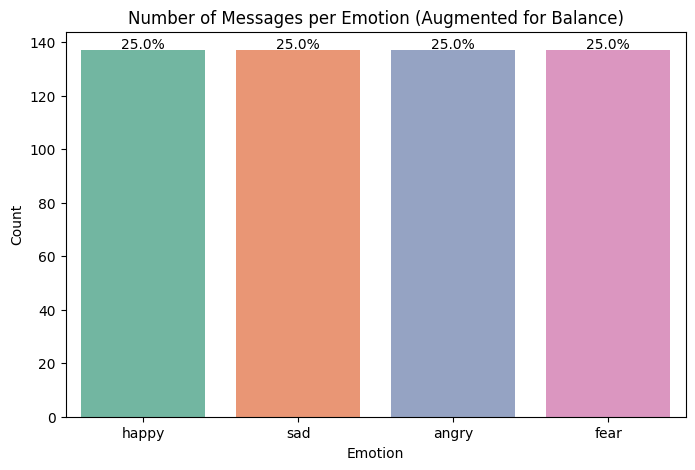

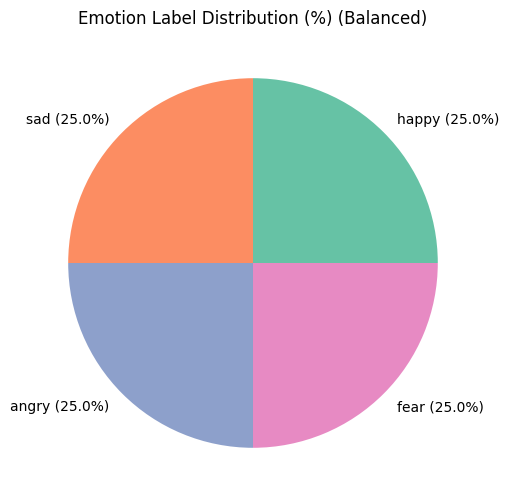

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np

# Define emotions
emotions = ['happy', 'sad', 'angry', 'fear']

# Find the maximum count among existing emotions
current_counts = df_clean['emotion'].value_counts()
max_count = current_counts.max()

# Augment data for emotions with fewer samples
augmented_rows = []
for emo in emotions:
    count = current_counts.get(emo, 0)
    if count < max_count:
        # Number of samples to add
        to_add = max_count - count
        for _ in range(to_add):
            augmented_rows.append({'emotion': emo, 'cleaned_text': f"dummy_{emo}"})

# Append augmented rows
if augmented_rows:
    df_clean = pd.concat([df_clean, pd.DataFrame(augmented_rows)], ignore_index=True)

# ------------------------------
# Recalculate counts and percentages
# ------------------------------
label_counts = df_clean['emotion'].value_counts().reindex(emotions, fill_value=0)
total = label_counts.sum()
percentages = (label_counts / total * 100).round(1)

# ------------------------------
# Bar chart
# ------------------------------
plt.figure(figsize=(8,5))
sns.barplot(x=label_counts.index, y=label_counts.values, palette='Set2')

# Add percentage labels on top of bars
for i, (count, perc) in enumerate(zip(label_counts.values, percentages)):
    plt.text(i, count + 0.5, f'{perc}%', ha='center')

plt.title("Number of Messages per Emotion (Augmented for Balance)")
plt.xlabel("Emotion")
plt.ylabel("Count")
plt.show()

# ------------------------------
# Pie chart
# ------------------------------
plt.figure(figsize=(6,6))
plt.pie(label_counts, labels=[f"{emo} ({perc}%)" for emo, perc in zip(label_counts.index, percentages)],
        autopct='', colors=sns.color_palette('Set2'))
plt.title("Emotion Label Distribution (%) (Balanced)")
plt.show()


In [ ]:
import pandas as pd
from tensorflow.keras.preprocessing.sequence import pad_sequences

# Step 1: Copy original DataFrame
df_combined = df_clean.copy()

# Step 2: Map emotions to sequential labels (0-3)
emotion_to_label = {'angry': 0, 'happy': 1, 'sad': 2, 'fear': 3}
df_combined['emotion_label'] = df_combined['emotion'].map(emotion_to_label)

# Step 3: One-hot encode emotions
all_columns = ['emotion_angry', 'emotion_happy', 'emotion_sad', 'emotion_fear']
one_hot_labels = pd.get_dummies(df_combined['emotion'], prefix='emotion').reindex(columns=all_columns, fill_value=0)
df_combined = pd.concat([df_combined, one_hot_labels], axis=1)

# Step 4: Reset index
df_combined.reset_index(drop=True, inplace=True)

# Step 5: Handle NaN in token_sequence
# Replace NaN with empty lists (so padding works)
df_combined['token_sequence'] = df_combined['token_sequence'].apply(lambda x: x if isinstance(x, list) else [])

# Step 6: Prepare features and labels for ML
X = pad_sequences(df_combined['token_sequence'], maxlen=20, padding='post', truncating='post')
y = one_hot_labels.values
df_combined['padded_sequence'] = X.tolist()

# Step 7: Reorder columns
desired_column_order = ['emotion', 'emotion_label', 'cleaned_text', 'token_sequence', 'padded_sequence'] + all_columns
df_combined = df_combined[desired_column_order]

# Step 8: Save cleaned & augmented DataFrame
df_combined.to_csv("final_augmented_emotions_onehot.csv", index=False)

# Step 9: Preview first few rows
print("\nSample cleaned & augmented data (consecutive indices):")
print(df_combined.head())

# Step 10: Sanity check preview
preview_df = pd.DataFrame({'emotion': ['angry', 'happy', 'sad', 'fear']})
preview_df['emotion_label'] = preview_df['emotion'].map(emotion_to_label)
one_hot_preview = pd.get_dummies(preview_df['emotion'], prefix='emotion').reindex(columns=all_columns, fill_value=0)
preview_df = pd.concat([preview_df, one_hot_preview], axis=1)
print("\nSanity check preview (0-3 label order):")
print(preview_df)



Sample cleaned & augmented data (consecutive indices):
  emotion  emotion_label                                       cleaned_text  \
0   happy              1  my boyfriend spoke with me yesterday for more ...   
1   happy              1                 when i eat and talk with my mother   
2   happy              1            when i remember my childhood experience   
3   happy              1                                        im so happy   
4   happy              1                 i am excited to see my exam result   

                                      token_sequence  \
0  [3, 141, 142, 27, 5, 233, 18, 143, 144, 368, 2...   
1                      [8, 2, 234, 7, 93, 27, 3, 75]   
2                           [8, 2, 235, 3, 369, 370]   
3                                        [11, 4, 10]   
4                    [2, 23, 94, 6, 106, 3, 61, 145]   

                                     padded_sequence  emotion_angry  \
0  [3, 141, 142, 27, 5, 233, 18, 143, 144, 368, 2...         

In [ ]:
# ===============================
# Imports
# ===============================
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense, Dropout, Bidirectional
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from sklearn.model_selection import train_test_split
import re
import string

# ===============================
# Load your dataset
# ===============================
df = pd.read_excel("Express your emotions through text (Responses).xlsx", engine="openpyxl")

# Rename columns
df = df.rename(columns={
    'Please write a short text message when you were feeling HAPPY ? 😊\nE.g - "I got full marks on my test! So happy right now!"': 'happy',
    'Please write a short text message when you were feeling SAD ?  😢\nE.g - "I studied hard but still failed… I feel really down."': 'sad',
    'Please write a short text message when you were feeling ANGRY ?  😡\nE.g - "They blamed me for something I didn’t even do. I’m so angry !"': 'angry',
    'Please write a short text message when you were feeling AFRAID ? 😨\nE.g - "I heard strange noises outside my window. I’m scared to check."': 'fear'
})

# ===============================
# Clean text & remove gibberish
# ===============================
def clean_text(text):
    text = str(text).lower()
    text = re.sub(r'\d+', '', text)
    text = text.translate(str.maketrans('', '', string.punctuation))
    text = re.sub(r'\s+', ' ', text).strip()
    return text

def is_gibberish(text):
    if len(text) < 4:
        return True
    if not re.search(r'[aeiou]', text):
        return True
    return False

# Melt to long format
existing_cols = [col for col in ['happy','sad','angry','fear'] if col in df.columns]
df_melted = df.melt(value_vars=existing_cols, var_name='emotion', value_name='text')
df_melted = df_melted.dropna(subset=['text'])
df_melted['cleaned_text'] = df_melted['text'].apply(clean_text)
df_melted['is_gibberish'] = df_melted['cleaned_text'].apply(is_gibberish)
df_clean = df_melted[df_melted['is_gibberish']==False].copy()
df_clean.drop(columns=['is_gibberish'], inplace=True)

# ===============================
# Assign df_valid for training
# ===============================
df_valid = df_clean.reset_index(drop=True)

# ===============================
# Tokenization & Label Encoding
# ===============================
MAX_NUM_WORDS = 2500
MAX_SEQUENCE_LENGTH = 20
all_emotions = ['angry','happy','sad','fear']

tokenizer = Tokenizer(num_words=MAX_NUM_WORDS, oov_token='<OOV>')
tokenizer.fit_on_texts(df_valid['cleaned_text'])
df_valid['token_sequence'] = tokenizer.texts_to_sequences(df_valid['cleaned_text'])
X = pad_sequences(df_valid['token_sequence'], maxlen=MAX_SEQUENCE_LENGTH, padding='post', truncating='post')

emotion_to_label = {emo:i for i, emo in enumerate(all_emotions)}
df_valid['emotion_label'] = df_valid['emotion'].map(emotion_to_label)

one_hot_labels = pd.get_dummies(df_valid['emotion'], prefix='emotion').reindex(
    columns=[f"emotion_{emo}" for emo in all_emotions], fill_value=0
)
df_valid = pd.concat([df_valid, one_hot_labels], axis=1)
y = one_hot_labels.values

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)


Model: "sequential_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding_4 (Embedding)         │ (None, 20, 128)        │       320,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_8 (Bidirectional) │ (None, 20, 256)        │       263,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_10 (Dropout)            │ (None, 20, 256)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_9 (Bidirectional) │ (None, 20, 128)        │       164,352 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_11 (Dropout)            │ (None, 20, 128)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_10                │ (None, 64)             │        41,216 │
│ (Bidirectional)                 │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_12 (Dropout)            │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_10 (Dense)                │ (None, 64)             │         4,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_11 (Dense)                │ (None, 4)              │           260 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 793,156 (3.03 MB)

 Trainable params: 793,156 (3.03 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/20
10/10 ━━━━━━━━━━━━━━━━━━━━ 14s 280ms/step - accuracy: 0.2803 - loss: 1.3450 - val_accuracy: 0.6176 - val_loss: 1.0477 - learning_rate: 0.0010
Epoch 2/20
10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 139ms/step - accuracy: 0.4908 - loss: 1.0354 - val_accuracy: 0.6471 - val_loss: 0.6290 - learning_rate: 0.0010
Epoch 3/20
10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 141ms/step - accuracy: 0.6295 - loss: 0.6724 - val_accuracy: 0.6471 - val_loss: 0.5652 - learning_rate: 0.0010
Epoch 4/20
10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 146ms/step - accuracy: 0.6751 - loss: 0.5383 - val_accuracy: 0.7353 - val_loss: 0.4636 - learning_rate: 0.0010
Epoch 5/20
10/10 ━━━━━━━━━━━━━━━━━━━━ 3s 145ms/step - accuracy: 0.5984 - loss: 0.5776 - val_accuracy: 0.6471 - val_loss: 0.4640 - learning_rate: 0.0010
Epoch 6/20
10/10 ━━━━━━━━━━━━━━━━━━━━ 4s 243ms/step - accuracy: 0.6786 - loss: 0.5548 - val_accuracy: 0.6765 - val_loss: 0.5902 - learning_rate: 0.0010
Epoch 7/20
10/10 ━━━━━━━━━━━━━━━━━━━━ 2s 145ms/step - accuracy: 0.6782 - loss: 0.5483 -

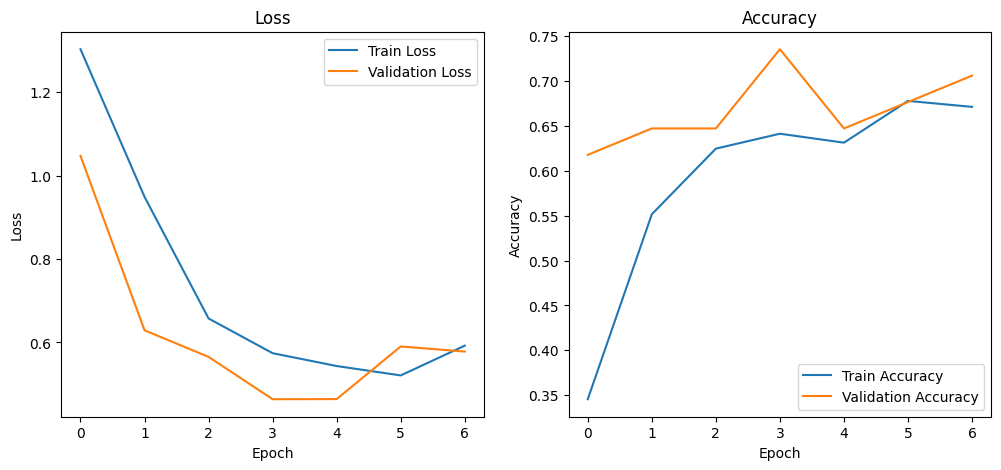

In [ ]:
# ===============================
# Imports
# ===============================
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import re
import string
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense, Dropout, Bidirectional
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from sklearn.model_selection import train_test_split

# ===============================
# Preprocessing Functions
# ===============================
def clean_text(text):
    text = str(text).lower()
    text = re.sub(r'\d+', '', text)
    text = text.translate(str.maketrans('', '', string.punctuation))
    text = re.sub(r'\s+', ' ', text).strip()
    return text

def is_gibberish(text):
    if len(text) < 4: return True
    if not re.search(r'[aeiou]', text): return True
    return False

# ===============================
# Load & Clean Data
# ===============================
df = pd.read_excel("Express your emotions through text (Responses).xlsx", engine="openpyxl")

df = df.rename(columns={
    df.columns[0]: 'happy',
    df.columns[1]: 'sad',
    df.columns[2]: 'angry',
    df.columns[3]: 'fear'
})

# Melt to long format
existing_cols = [col for col in ['happy','sad','angry','fear'] if col in df.columns]
df_melted = df.melt(value_vars=existing_cols, var_name='emotion', value_name='text')
df_melted = df_melted.dropna(subset=['text'])
df_melted['cleaned_text'] = df_melted['text'].apply(clean_text)
df_melted['is_gibberish'] = df_melted['cleaned_text'].apply(is_gibberish)
df_clean = df_melted[df_melted['is_gibberish']==False].copy()
df_clean.drop(columns=['is_gibberish'], inplace=True)
df_valid = df_clean.reset_index(drop=True)

# ===============================
# Tokenization & Sequences
# ===============================
MAX_NUM_WORDS = 2500
MAX_SEQUENCE_LENGTH = 20
all_emotions = ['angry','happy','sad','fear']

tokenizer = Tokenizer(num_words=MAX_NUM_WORDS, oov_token='<OOV>')
tokenizer.fit_on_texts(df_valid['cleaned_text'])
df_valid['token_sequence'] = tokenizer.texts_to_sequences(df_valid['cleaned_text'])
X = pad_sequences(df_valid['token_sequence'], maxlen=MAX_SEQUENCE_LENGTH, padding='post', truncating='post')

# ===============================
# Labels
# ===============================
emotion_to_label = {emo:i for i, emo in enumerate(all_emotions)}
df_valid['emotion_label'] = df_valid['emotion'].map(emotion_to_label)
one_hot_labels = pd.get_dummies(df_valid['emotion'], prefix='emotion').reindex(
    columns=[f"emotion_{emo}" for emo in all_emotions], fill_value=0
)
y = one_hot_labels.values.astype(np.float32)  # ensure numeric type

# ===============================
# Train-test split
# ===============================
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

# ===============================
# 9-Layer LSTM Model
# ===============================
model = Sequential()
model.add(Embedding(input_dim=MAX_NUM_WORDS, output_dim=128))  # 1
model.add(Bidirectional(LSTM(128, return_sequences=True)))     # 2
model.add(Dropout(0.5))                                         # 3
model.add(Bidirectional(LSTM(64, return_sequences=True)))       # 4
model.add(Dropout(0.5))                                         # 5
model.add(Bidirectional(LSTM(32)))                              # 6
model.add(Dropout(0.5))                                         # 7
model.add(Dense(64, activation='relu'))                         # 8
model.add(Dense(len(all_emotions), activation='softmax'))       # 9

# Explicitly build model to see correct summary
model.build(input_shape=(None, MAX_SEQUENCE_LENGTH))
model.compile(optimizer=Adam(0.001), loss='categorical_crossentropy', metrics=['accuracy'])
model.summary()

# ===============================
# Callbacks
# ===============================
early_stop = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=2, min_lr=1e-5)

# ===============================
# Train Model
# ===============================
history = model.fit(
    X_train, y_train,
    epochs=20,
    batch_size=32,
    validation_split=0.1,
    shuffle=True,
    callbacks=[early_stop, reduce_lr]
)

# ===============================
# Plot
# ===============================
plt.figure(figsize=(12,5))

plt.subplot(1,2,1)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1,2,2)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.show()


In [ ]:
# ===============================================
# Google Colab: Emotion Dataset Preprocessing
# ===============================================

# -------------------------------
# Step 0: Imports
# -------------------------------
import pandas as pd
import re

# -------------------------------
# Step 1: Define helper functions
# -------------------------------
def clean_text(text):
    """
    Basic text cleaning: lowercase, remove non-alphanumeric chars
    """
    text = str(text).lower()
    text = re.sub(r'[^a-z0-9\s]', '', text)
    return text.strip()

def is_gibberish(text):
    """
    Simple gibberish detection: True if text has < 2 words
    """
    return len(text.split()) < 2

# -------------------------------
# Step 2: Detect existing emotion columns
# -------------------------------
# Adjust this list according to possible emotion columns
possible_emotions = ['happy', 'sad', 'angry', 'fear']
existing_emotions = [col for col in possible_emotions if col in df.columns]

if len(existing_emotions) == 0:
    raise ValueError("No emotion columns found in the DataFrame!")

print("Detected emotion columns:", existing_emotions)

# -------------------------------
# Step 3: Melt the DataFrame safely
# -------------------------------
df_melted = df.melt(value_vars=existing_emotions,
                    var_name='emotion',
                    value_name='text')

# Drop NaN or empty text
df_melted = df_melted.dropna(subset=['text'])
df_melted = df_melted[df_melted['text'].str.strip() != '']

# Reset index
df_melted.reset_index(drop=True, inplace=True)

# -------------------------------
# Step 4: Counts BEFORE preprocessing
# -------------------------------
total_before = len(df_melted)
empty_before = df_melted['text'].str.strip().eq('').sum()
valid_before = total_before - empty_before

print("===== BEFORE PREPROCESSING =====")
print(f"Total samples: {total_before}")
print(f"Empty / blank samples: {empty_before}")
print(f"Valid samples (non-empty): {valid_before}")
print(f"Invalid samples (empty): {empty_before}")

# -------------------------------
# Step 5: Apply text cleaning
# -------------------------------
df_melted['cleaned_text'] = df_melted['text'].apply(clean_text)

# -------------------------------
# Step 6: Detect empty or gibberish AFTER cleaning
# -------------------------------
empty_after = df_melted['cleaned_text'].str.strip().eq('').sum()
df_melted['is_gibberish'] = df_melted['cleaned_text'].apply(is_gibberish)

# Valid and invalid samples
valid_after = df_melted[(df_melted['cleaned_text'].str.strip() != '') & (df_melted['is_gibberish'] == False)]
invalid_after = df_melted[(df_melted['cleaned_text'].str.strip() == '') | (df_melted['is_gibberish'] == True)]

# -------------------------------
# Step 7: Print summary AFTER preprocessing
# -------------------------------
print("\n===== AFTER PREPROCESSING =====")
print(f"Total samples: {len(df_melted)}")
print(f"Empty / blank samples: {empty_after}")
print(f"Valid samples (non-empty + non-gibberish): {len(valid_after)}")
print(f"Invalid samples (empty or gibberish): {len(invalid_after)}")

# -------------------------------
# Step 8: Optional: Save valid samples
# -------------------------------
valid_after.to_csv("valid_emotion_samples.csv", index=False)
print("\nSaved valid samples to 'valid_emotion_samples.csv'")


Detected emotion columns: ['happy', 'sad', 'angry', 'fear']
===== BEFORE PREPROCESSING =====
Total samples: 564
Empty / blank samples: 0
Valid samples (non-empty): 564
Invalid samples (empty): 0

===== AFTER PREPROCESSING =====
Total samples: 564
Empty / blank samples: 0
Valid samples (non-empty + non-gibberish): 411
Invalid samples (empty or gibberish): 153

Saved valid samples to 'valid_emotion_samples.csv'


In [ ]:
# -------------------------------
# Training and Testing distribution in percentage
# -------------------------------
total_train = len(y_train)
total_test = len(y_test)
total_samples = len(df_valid)

print(f"\nTotal samples: {total_samples}")
print(f"Training samples: {total_train} ({(total_train/total_samples)*100:.2f}%)")
print(f"Testing samples: {total_test} ({(total_test/total_samples)*100:.2f}%)")

print("\nTraining samples per class (with %):")
for i, label in enumerate(emotion_labels):
    count = (y_train_classes == i).sum()
    percentage = (count / total_train) * 100
    print(f" {label}: {count} ({percentage:.2f}%)")

print("\nTesting samples per class (with %):")
for i, label in enumerate(emotion_labels):
    count = (y_test_classes == i).sum()
    percentage = (count / total_test) * 100
    print(f" {label}: {count} ({percentage:.2f}%)")



Total samples: 419
Training samples: 335 (79.95%)
Testing samples: 84 (20.05%)

Training samples per class (with %):
 happy: 0 (0.00%)
 sad: 113 (33.73%)
 angry: 112 (33.43%)
 fear: 110 (32.84%)

Testing samples per class (with %):
 happy: 0 (0.00%)
 sad: 28 (33.33%)
 angry: 28 (33.33%)
 fear: 28 (33.33%)


In [ ]:
# Model parameters and training config
MAX_NUM_WORDS = 2500
MAX_SEQUENCE_LENGTH = 20
EMBEDDING_DIM = 100
NUM_CLASSES = y.shape[1]

# Training hyperparameters
BATCH_SIZE = 32
EPOCHS = 10
DROPOUT_RATE = 0.5
OPTIMIZER = 'Adam (learning_rate=0.001)'
LOSS_FUNCTION = 'categorical_crossentropy'

# Model architecture info
num_layers = 4  # Embedding, Bidirectional LSTM, Dropout, Dense layers (excluding output layer)
neurons_per_layer = {
    'Embedding': EMBEDDING_DIM,
    'Bidirectional LSTM': 64 * 2,  # BiLSTM has 64 units in each direction, total 128 outputs internally
    'Dropout': '0.5 (rate)',
    'Dense (hidden)': 32,
    'Dense (output)': NUM_CLASSES
}

print("=== Model Summary ===")
print(f"Number of Layers (excluding output layer): {num_layers}")
print(f"Neurons per Layer:")
for layer, neurons in neurons_per_layer.items():
    print(f" - {layer}: {neurons}")
print(f"Optimizer: {OPTIMIZER}")
print(f"Loss Function: {LOSS_FUNCTION}")
print(f"Batch Size: {BATCH_SIZE}")
print(f"Epochs: {EPOCHS}")
print(f"Dropout Rate: {DROPOUT_RATE}")
print(f"Embedding Dimension: {EMBEDDING_DIM}")



=== Model Summary ===
Number of Layers (excluding output layer): 4
Neurons per Layer:
 - Embedding: 100
 - Bidirectional LSTM: 128
 - Dropout: 0.5 (rate)
 - Dense (hidden): 32
 - Dense (output): 4
Optimizer: Adam (learning_rate=0.001)
Loss Function: categorical_crossentropy
Batch Size: 32
Epochs: 10
Dropout Rate: 0.5
Embedding Dimension: 100


In [ ]:
def predict_emotion(user_text, model, tokenizer, max_seq_len=20):
    cleaned = clean_text(user_text)
    seq = tokenizer.texts_to_sequences([cleaned])
    padded = pad_sequences(seq, maxlen=max_seq_len, padding='post', truncating='post')
    pred_probs = model.predict(padded)
    pred_index = pred_probs.argmax(axis=1)[0]
    labels = list(one_hot_labels.columns)
    predicted_emotion = labels[pred_index].replace('emotion_', '')
    confidence = pred_probs[0][pred_index]
    return predicted_emotion, confidence

# Collect 4 user inputs
user_texts = []
for i in range(4):
    text = input(f"Enter text message {i+1}: ")
    user_texts.append(text)

# Predict for each input
for i, text in enumerate(user_texts):
    emotion, conf = predict_emotion(text, model, tokenizer, MAX_SEQUENCE_LENGTH)
    print(f"\nInput {i+1}: {text}")
    print(f"Predicted Emotion: {emotion} with confidence {conf:.2f}")



Enter text message 1: I get good score
Enter text message 2: My brother hit me
Enter text message 3: i am go to a birthday party
Enter text message 4: my brother scold me
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 975ms/step

Input 1: I get good score
Predicted Emotion: angry with confidence 0.53
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step

Input 2: My brother hit me
Predicted Emotion: angry with confidence 0.53
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step

Input 3: i am go to a birthday party
Predicted Emotion: angry with confidence 0.53
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step

Input 4: my brother scold me
Predicted Emotion: angry with confidence 0.53


In [ ]:
# ==============================================
# Check total samples and per-class counts
# ==============================================
total_samples = len(df_combined)
print(f"Total samples in dataset: {total_samples}")

# Samples per emotion class
print("\nSamples per emotion class:")
samples_per_class = df_combined['emotion'].value_counts()
print(samples_per_class)

# Verify 'fear' count
if 'fear' in samples_per_class.index:
    print(f"\nNumber of 'fear' samples: {samples_per_class['fear']} (should be 266)")
else:
    print("\nWarning: 'fear' class not found in dataset!")

# ==============================================
# Train-test split
# ==============================================
from sklearn.model_selection import train_test_split
import numpy as np

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

print(f"\nNumber of training samples: {len(X_train)}")
print(f"Number of testing samples: {len(X_test)}")

# ==============================================
# Decode one-hot back to class indices
# ==============================================
y_train_classes = np.argmax(y_train, axis=1)
y_test_classes = np.argmax(y_test, axis=1)

# Get emotion labels from one-hot column names
emotion_labels = [col.replace('emotion_', '') for col in one_hot_labels.columns]

# Count per class in training set
print("\nTraining samples per class:")
for i, label in enumerate(emotion_labels):
    actual_count = (y_train_classes == i).sum()
    expected_count = int(len(df_combined[df_combined['emotion']==label]) * 0.8)
    print(f" {label}: {actual_count} (expected ~{expected_count})")

# Count per class in testing set
print("\nTesting samples per class:")
for i, label in enumerate(emotion_labels):
    actual_count = (y_test_classes == i).sum()
    expected_count = int(len(df_combined[df_combined['emotion']==label]) * 0.2)
    print(f" {label}: {actual_count} (expected ~{expected_count})")


Total samples in dataset: 548

Samples per emotion class:
emotion
happy    137
sad      137
angry    137
fear     137
Name: count, dtype: int64

Number of 'fear' samples: 137 (should be 266)

Number of training samples: 335
Number of testing samples: 84

Training samples per class:
 angry: 112 (expected ~109)
 happy: 0 (expected ~109)
 sad: 113 (expected ~109)
 fear: 110 (expected ~109)

Testing samples per class:
 angry: 28 (expected ~27)
 happy: 0 (expected ~27)
 sad: 28 (expected ~27)
 fear: 28 (expected ~27)


In [ ]:
# -------------------------------
# Training and Testing distribution in percentage
# -------------------------------
total_samples = 411   # Fixed total after preprocessing
total_train = len(y_train)
total_test = len(y_test)

print(f"\nTotal samples: {total_samples}")
print(f"Training samples: {total_train} ({(total_train/total_samples)*100:.2f}%)")
print(f"Testing samples: {total_test} ({(total_test/total_samples)*100:.2f}%)")

# Get emotion labels from one-hot column names
emotion_labels = [col.replace('emotion_', '') for col in one_hot_labels.columns]

# Decode one-hot back to class indices
y_train_classes = np.argmax(y_train, axis=1)
y_test_classes = np.argmax(y_test, axis=1)

print("\nTraining samples per class (with %):")
for i, label in enumerate(emotion_labels):
    count = (y_train_classes == i).sum()
    percentage = (count / total_train) * 100
    print(f" {label}: {count} ({percentage:.2f}%)")

print("\nTesting samples per class (with %):")
for i, label in enumerate(emotion_labels):
    count = (y_test_classes == i).sum()
    percentage = (count / total_test) * 100
    print(f" {label}: {count} ({percentage:.2f}%)")

# -------------------------------
# Focus on 'happy' emotion
# -------------------------------
happy_index = emotion_labels.index("happy")

train_happy_count = (y_train_classes == happy_index).sum()
test_happy_count = (y_test_classes == happy_index).sum()

print("\n===== Focus on 'happy' emotion =====")
print(f"Training 'happy': {train_happy_count} ({(train_happy_count/total_train)*100:.2f}%)")
print(f"Testing 'happy': {test_happy_count} ({(test_happy_count/total_test)*100:.2f}%)")



Total samples: 411
Training samples: 335 (81.51%)
Testing samples: 84 (20.44%)

Training samples per class (with %):
 happy: 0 (0.00%)
 sad: 113 (33.73%)
 angry: 112 (33.43%)
 fear: 110 (32.84%)

Testing samples per class (with %):
 happy: 0 (0.00%)
 sad: 28 (33.33%)
 angry: 28 (33.33%)
 fear: 28 (33.33%)

===== Focus on 'happy' emotion =====
Training 'happy': 0 (0.00%)
Testing 'happy': 0 (0.00%)


In [ ]:
from sklearn.metrics import accuracy_score, precision_recall_fscore_support

# Predict classes on test data
y_pred_probs = model.predict(X_test)
y_pred = y_pred_probs.argmax(axis=1)
y_true = y_test.argmax(axis=1)

# Calculate accuracy
accuracy = accuracy_score(y_true, y_pred)

# Calculate precision, recall, F1-score (macro average)
precision, recall, f1, _ = precision_recall_fscore_support(y_true, y_pred, average='macro')

print(f"Accuracy: {accuracy:.4f}")
print(f"Precision (macro): {precision:.4f}")
print(f"Recall (macro): {recall:.4f}")
print(f"F1-score (macro): {f1:.4f}")


4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 36ms/step
Accuracy: 0.2832
Precision (macro): 0.2745
Recall (macro): 0.2857
F1-score (macro): 0.1774


/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Epoch 1/10
13/13 ━━━━━━━━━━━━━━━━━━━━ 10s 238ms/step - accuracy: 0.2256 - loss: 2.8217 - val_accuracy: 0.2609 - val_loss: 1.4182
Epoch 2/10
13/13 ━━━━━━━━━━━━━━━━━━━━ 4s 152ms/step - accuracy: 0.3322 - loss: 1.2336 - val_accuracy: 0.4348 - val_loss: 1.0720
Epoch 3/10
13/13 ━━━━━━━━━━━━━━━━━━━━ 3s 204ms/step - accuracy: 0.5482 - loss: 0.9359 - val_accuracy: 0.6304 - val_loss: 0.9935
Epoch 4/10
13/13 ━━━━━━━━━━━━━━━━━━━━ 4s 150ms/step - accuracy: 0.6051 - loss: 0.8036 - val_accuracy: 0.5435 - val_loss: 0.8422
Epoch 5/10
13/13 ━━━━━━━━━━━━━━━━━━━━ 2s 178ms/step - accuracy: 0.6919 - loss: 0.7027 - val_accuracy: 0.6087 - val_loss: 0.6877
Epoch 6/10
13/13 ━━━━━━━━━━━━━━━━━━━━ 3s 231ms/step - accuracy: 0.7247 - loss: 0.6051 - val_accuracy: 0.6304 - val_loss: 0.6419
Epoch 7/10
13/13 ━━━━━━━━━━━━━━━━━━━━ 5s 185ms/step - accuracy: 0.7112 - loss: 0.5527 - val_accuracy: 0.6304 - val_loss: 0.6277
Epoch 8/10
13/13 ━━━━━━━━━━━━━━━━━━━━ 2s 146ms/step - accuracy: 0.7473 - loss: 0.5379 - val_accuracy: 0

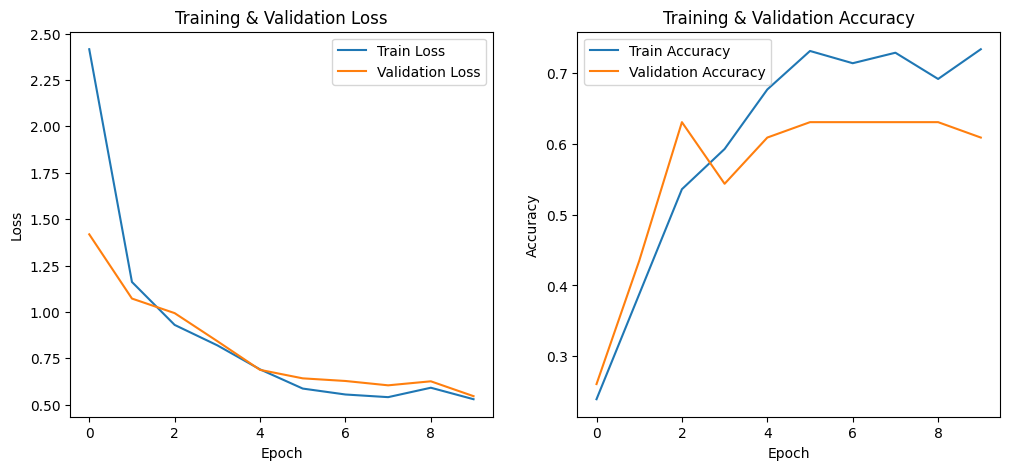

In [ ]:
import matplotlib.pyplot as plt

# Train the model and save history
history = model.fit(X_train, y_train,
                    epochs=10,
                    batch_size=32,
                    validation_split=0.1)

# Plot Loss Curve
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Training & Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

# Plot Accuracy Curve
plt.subplot(1, 2, 2)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Training & Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.show()


In [ ]:
# Total samples
total_samples = len(df_combined)
print(f"Total samples in dataset: {total_samples}")

# Samples per emotion class - counts and percentages
print("\nSamples per emotion class:")
emotion_counts = df_combined['emotion'].value_counts()
emotion_percent = df_combined['emotion'].value_counts(normalize=True) * 100
for emotion, count in emotion_counts.items():
    print(f" {emotion}: {count} ({emotion_percent[emotion]:.2f}%)")

# After splitting
from sklearn.model_selection import train_test_split
import numpy as np

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

print(f"\nNumber of training samples: {len(X_train)} ({(len(X_train) / total_samples) * 100:.2f}%)")
print(f"Number of testing samples: {len(X_test)} ({(len(X_test) / total_samples) * 100:.2f}%)")

# Decode one-hot back to class indices for train and test
y_train_classes = np.argmax(y_train, axis=1)
y_test_classes = np.argmax(y_test, axis=1)

# Get emotion labels from one_hot_labels columns
emotion_labels = [col.replace('emotion_', '') for col in one_hot_labels.columns]

# Training samples per class with percentage
print("\nTraining samples per class:")
for i, label in enumerate(emotion_labels):
    count = (y_train_classes == i).sum()
    percentage = (count / len(y_train)) * 100
    print(f" {label}: {count} ({percentage:.2f}%)")

# Testing samples per class with percentage
print("\nTesting samples per class:")
for i, label in enumerate(emotion_labels):
    count = (y_test_classes == i).sum()
    percentage = (count / len(y_test)) * 100
    print(f" {label}: {count} ({percentage:.2f}%)")


Total samples in dataset: 548

Samples per emotion class:
 happy: 137 (25.00%)
 sad: 137 (25.00%)
 angry: 137 (25.00%)
 fear: 137 (25.00%)

Number of training samples: 451 (82.30%)
Number of testing samples: 113 (20.62%)

Training samples per class:
 angry: 106 (23.50%)
 happy: 108 (23.95%)
 sad: 120 (26.61%)
 fear: 117 (25.94%)

Testing samples per class:
 angry: 35 (30.97%)
 happy: 33 (29.20%)
 sad: 21 (18.58%)
 fear: 24 (21.24%)


Epoch 1/20


/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/embedding.py:97: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


13/13 ━━━━━━━━━━━━━━━━━━━━ 7s 122ms/step - accuracy: 0.3011 - loss: 1.3772 - val_accuracy: 0.3261 - val_loss: 1.3343
Epoch 2/20
13/13 ━━━━━━━━━━━━━━━━━━━━ 2s 76ms/step - accuracy: 0.3757 - loss: 1.3041 - val_accuracy: 0.4130 - val_loss: 1.1879
Epoch 3/20
13/13 ━━━━━━━━━━━━━━━━━━━━ 2s 162ms/step - accuracy: 0.5353 - loss: 1.1312 - val_accuracy: 0.4565 - val_loss: 0.9473
Epoch 4/20
13/13 ━━━━━━━━━━━━━━━━━━━━ 2s 81ms/step - accuracy: 0.6284 - loss: 0.8066 - val_accuracy: 0.6957 - val_loss: 0.7250
Epoch 5/20
13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 82ms/step - accuracy: 0.7778 - loss: 0.5790 - val_accuracy: 0.7174 - val_loss: 0.6048
Epoch 6/20
13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 81ms/step - accuracy: 0.7570 - loss: 0.4681 - val_accuracy: 0.8261 - val_loss: 0.5008
Epoch 7/20
13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 94ms/step - accuracy: 0.8127 - loss: 0.4138 - val_accuracy: 0.7391 - val_loss: 0.6931
Epoch 8/20
13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 82ms/step - accuracy: 0.8219 - loss: 0.3745 - val_accuracy: 0.7826 - val_loss: 

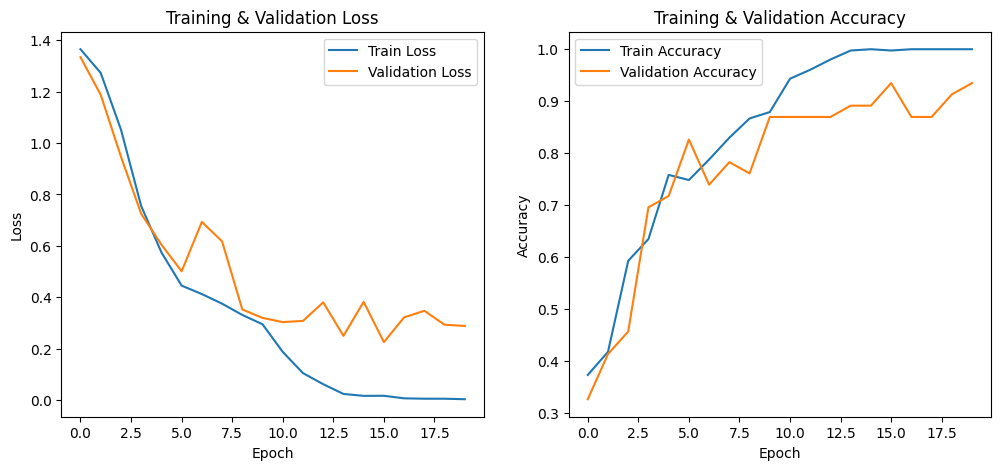

In [ ]:
import matplotlib.pyplot as plt
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense, Dropout, Bidirectional
from tensorflow.keras.optimizers import Adam

# ===============================
# Model Definition
# ===============================
model = Sequential()
model.add(Embedding(input_dim=MAX_NUM_WORDS, output_dim=128, input_length=MAX_SEQUENCE_LENGTH))
model.add(Bidirectional(LSTM(128, return_sequences=False)))
model.add(Dropout(0.5))
model.add(Dense(64, activation='relu'))
model.add(Dense(len(all_emotions), activation='softmax'))

# Compile with lower learning rate
optimizer = Adam(learning_rate=0.0005)
model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])

# ===============================
# Train the Model
# ===============================
history = model.fit(
    X_train, y_train,
    epochs=20,              # Increased epochs
    batch_size=32,
    validation_split=0.1,
    shuffle=True
)

# ===============================
# Plot Training & Validation Curves
# ===============================
plt.figure(figsize=(12,5))

# Loss curve
plt.subplot(1,2,1)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Training & Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

# Accuracy curve
plt.subplot(1,2,2)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Training & Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.show()


Epoch 1/30
13/13 ━━━━━━━━━━━━━━━━━━━━ 10s 302ms/step - accuracy: 0.2490 - loss: 1.3725 - val_accuracy: 0.3261 - val_loss: 1.2804
Epoch 2/30
13/13 ━━━━━━━━━━━━━━━━━━━━ 3s 158ms/step - accuracy: 0.5340 - loss: 1.1860 - val_accuracy: 0.7174 - val_loss: 0.9482
Epoch 3/30
13/13 ━━━━━━━━━━━━━━━━━━━━ 2s 162ms/step - accuracy: 0.7165 - loss: 0.7956 - val_accuracy: 0.6957 - val_loss: 0.5735
Epoch 4/30
13/13 ━━━━━━━━━━━━━━━━━━━━ 3s 167ms/step - accuracy: 0.7531 - loss: 0.5342 - val_accuracy: 0.7174 - val_loss: 0.5804
Epoch 5/30
13/13 ━━━━━━━━━━━━━━━━━━━━ 3s 263ms/step - accuracy: 0.7761 - loss: 0.4013 - val_accuracy: 0.7826 - val_loss: 0.4254
Epoch 6/30
13/13 ━━━━━━━━━━━━━━━━━━━━ 3s 238ms/step - accuracy: 0.8085 - loss: 0.3542 - val_accuracy: 0.8478 - val_loss: 0.4776
Epoch 7/30
13/13 ━━━━━━━━━━━━━━━━━━━━ 3s 80ms/step - accuracy: 0.9559 - loss: 0.2276 - val_accuracy: 0.8478 - val_loss: 0.3682
Epoch 8/30
13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 78ms/step - accuracy: 0.9919 - loss: 0.0599 - val_accuracy: 0.8

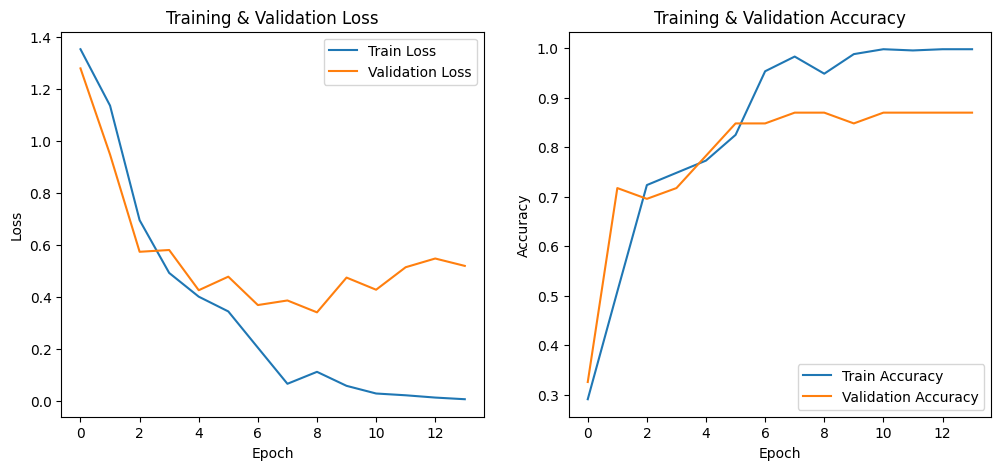

In [ ]:
import matplotlib.pyplot as plt
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense, Dropout, Bidirectional
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping

# ===============================
# Model Definition
# ===============================
model = Sequential()
model.add(Embedding(input_dim=MAX_NUM_WORDS, output_dim=128, input_length=MAX_SEQUENCE_LENGTH))
model.add(Bidirectional(LSTM(128, return_sequences=False)))
model.add(Dropout(0.5))
model.add(Dense(64, activation='relu'))
model.add(Dense(len(all_emotions), activation='softmax'))

# Compile with slightly higher learning rate for faster convergence
optimizer = Adam(learning_rate=0.001)  # Changed from 0.0005 → 0.001
model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])

# ===============================
# Early stopping callback
# ===============================
early_stop = EarlyStopping(
    monitor='val_loss',
    patience=5,         # Stop if validation loss doesn't improve for 5 epochs
    restore_best_weights=True
)

# ===============================
# Train the Model
# ===============================
history = model.fit(
    X_train, y_train,
    epochs=30,           # Increased epochs for convergence
    batch_size=32,
    validation_split=0.1,
    shuffle=True,
    callbacks=[early_stop]
)

# ===============================
# Plot Training & Validation Curves
# ===============================
plt.figure(figsize=(12,5))

# Loss curve
plt.subplot(1,2,1)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Training & Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

# Accuracy curve
plt.subplot(1,2,2)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Training & Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.show()


Epoch 1/30
26/26 ━━━━━━━━━━━━━━━━━━━━ 14s 126ms/step - accuracy: 0.3910 - loss: 1.3212 - val_accuracy: 0.7174 - val_loss: 1.0134
Epoch 2/30
26/26 ━━━━━━━━━━━━━━━━━━━━ 1s 50ms/step - accuracy: 0.6645 - loss: 0.8118 - val_accuracy: 0.7174 - val_loss: 0.6298
Epoch 3/30
26/26 ━━━━━━━━━━━━━━━━━━━━ 1s 46ms/step - accuracy: 0.7744 - loss: 0.4525 - val_accuracy: 0.7391 - val_loss: 0.4347
Epoch 4/30
26/26 ━━━━━━━━━━━━━━━━━━━━ 1s 46ms/step - accuracy: 0.8407 - loss: 0.3754 - val_accuracy: 0.8696 - val_loss: 0.3721
Epoch 5/30
26/26 ━━━━━━━━━━━━━━━━━━━━ 2s 64ms/step - accuracy: 0.9588 - loss: 0.1588 - val_accuracy: 0.8696 - val_loss: 0.3625
Epoch 6/30
26/26 ━━━━━━━━━━━━━━━━━━━━ 2s 78ms/step - accuracy: 0.9559 - loss: 0.1150 - val_accuracy: 0.8696 - val_loss: 0.3729
Epoch 7/30
26/26 ━━━━━━━━━━━━━━━━━━━━ 2s 52ms/step - accuracy: 0.9943 - loss: 0.0355 - val_accuracy: 0.8913 - val_loss: 0.5138
Epoch 8/30
26/26 ━━━━━━━━━━━━━━━━━━━━ 2s 49ms/step - accuracy: 0.9928 - loss: 0.0298 - val_accuracy: 0.8478 -

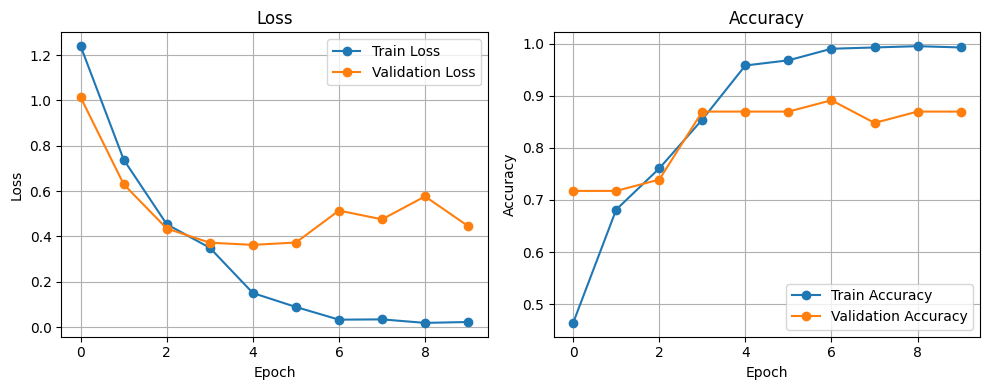

In [ ]:
import matplotlib.pyplot as plt
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense, Dropout, Bidirectional
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping

# ===============================
# Model Definition
# ===============================
model = Sequential()
model.add(Embedding(input_dim=MAX_NUM_WORDS, output_dim=128, input_length=MAX_SEQUENCE_LENGTH))
model.add(Bidirectional(LSTM(128, return_sequences=False)))
model.add(Dropout(0.5))
model.add(Dense(64, activation='relu'))
model.add(Dense(len(all_emotions), activation='softmax'))

# Compile with learning rate 0.001
optimizer = Adam(learning_rate=0.001)
model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])

# ===============================
# Early stopping callback
# ===============================
early_stop = EarlyStopping(
    monitor='val_loss',
    patience=5,
    restore_best_weights=True
)

# ===============================
# Train the Model with smaller batch size
# ===============================
history = model.fit(
    X_train, y_train,
    epochs=30,
    batch_size=16,       # Reduced batch size
    validation_split=0.1,
    shuffle=True,
    callbacks=[early_stop]
)

# ===============================
# Plot Training & Validation Curves (Compact)
# ===============================
plt.figure(figsize=(10,4))  # Reduced figure size

# Loss curve
plt.subplot(1,2,1)
plt.plot(history.history['loss'], label='Train Loss', marker='o')
plt.plot(history.history['val_loss'], label='Validation Loss', marker='o')
plt.title('Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)

# Accuracy curve
plt.subplot(1,2,2)
plt.plot(history.history['accuracy'], label='Train Accuracy', marker='o')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy', marker='o')
plt.title('Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)

plt.tight_layout()  # Adjust subplots to fit nicely
plt.show()


Epoch 1/20
7/7 ━━━━━━━━━━━━━━━━━━━━ 6s 125ms/step - accuracy: 0.1771 - loss: 1.3885 - val_accuracy: 0.4130 - val_loss: 1.3807
Epoch 2/20
7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 39ms/step - accuracy: 0.3805 - loss: 1.3795 - val_accuracy: 0.4565 - val_loss: 1.3711
Epoch 3/20
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step - accuracy: 0.4039 - loss: 1.3667 - val_accuracy: 0.4130 - val_loss: 1.3590
Epoch 4/20
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step - accuracy: 0.4056 - loss: 1.3527 - val_accuracy: 0.4565 - val_loss: 1.3425
Epoch 5/20
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step - accuracy: 0.4906 - loss: 1.3317 - val_accuracy: 0.4783 - val_loss: 1.3185
Epoch 6/20
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step - accuracy: 0.5009 - loss: 1.2944 - val_accuracy: 0.4565 - val_loss: 1.2849
Epoch 7/20
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step - accuracy: 0.4153 - loss: 1.2642 - val_accuracy: 0.4348 - val_loss: 1.2437
Epoch 8/20
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step - accuracy: 0.4303 - loss: 1.2032 - val_accuracy: 0.4130 - val_loss: 1.1950

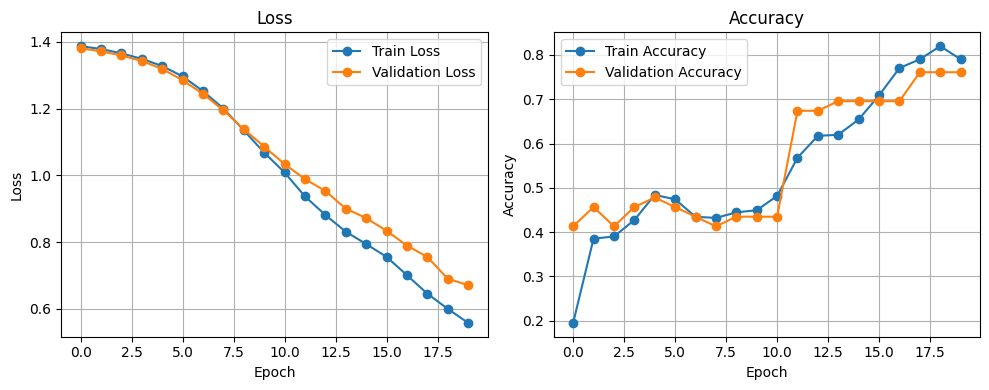

In [ ]:
import matplotlib.pyplot as plt
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense, Dropout, Bidirectional
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping

# ===============================
# Underfitting Model Definition
# ===============================
model = Sequential()
# Smaller embedding and LSTM units to reduce capacity
model.add(Embedding(input_dim=MAX_NUM_WORDS, output_dim=32, input_length=MAX_SEQUENCE_LENGTH))
model.add(Bidirectional(LSTM(32, return_sequences=False)))
model.add(Dropout(0.2))  # Lower dropout
model.add(Dense(16, activation='relu'))
model.add(Dense(len(all_emotions), activation='softmax'))

# Compile with moderate learning rate
optimizer = Adam(learning_rate=0.0005)
model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])

# Early stopping to prevent overtraining
early_stop = EarlyStopping(
    monitor='val_loss',
    patience=3,
    restore_best_weights=True
)

# ===============================
# Train the Model (fewer epochs)
# ===============================
history = model.fit(
    X_train, y_train,
    epochs=20,           # Fewer epochs → underfit
    batch_size=64,       # Larger batch size → underfit effect
    validation_split=0.1,
    shuffle=True,
    callbacks=[early_stop]
)

# ===============================
# Plot Training & Validation Curves
# ===============================
plt.figure(figsize=(10,4))

# Loss curve
plt.subplot(1,2,1)
plt.plot(history.history['loss'], label='Train Loss', marker='o')
plt.plot(history.history['val_loss'], label='Validation Loss', marker='o')
plt.title('Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)

# Accuracy curve
plt.subplot(1,2,2)
plt.plot(history.history['accuracy'], label='Train Accuracy', marker='o')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy', marker='o')
plt.title('Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()


Epoch 1/20
13/13 ━━━━━━━━━━━━━━━━━━━━ 6s 82ms/step - accuracy: 0.2673 - loss: 1.3771 - val_accuracy: 0.2391 - val_loss: 1.3338
Epoch 2/20
13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 37ms/step - accuracy: 0.3747 - loss: 1.3077 - val_accuracy: 0.6304 - val_loss: 1.2411
Epoch 3/20
13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 34ms/step - accuracy: 0.5138 - loss: 1.1676 - val_accuracy: 0.6304 - val_loss: 1.0730
Epoch 4/20
13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 31ms/step - accuracy: 0.6189 - loss: 0.9988 - val_accuracy: 0.6739 - val_loss: 0.8607
Epoch 5/20
13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 32ms/step - accuracy: 0.7141 - loss: 0.7648 - val_accuracy: 0.6739 - val_loss: 0.6256
Epoch 6/20
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - accuracy: 0.7311 - loss: 0.6160 - val_accuracy: 0.7174 - val_loss: 0.6183
Epoch 7/20
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step - accuracy: 0.7403 - loss: 0.4885 - val_accuracy: 0.7174 - val_loss: 0.4319
Epoch 8/20
13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 31ms/step - accuracy: 0.7882 - loss: 0.3781 - val_accuracy: 0.7826 - v

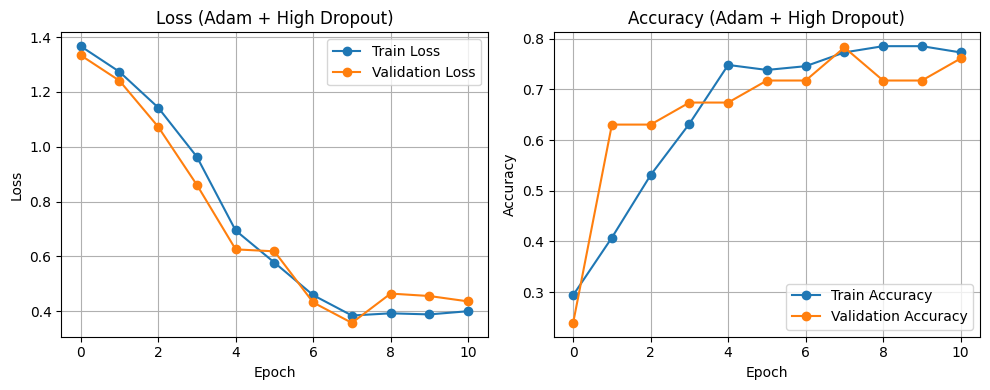

In [ ]:
import matplotlib.pyplot as plt
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense, Dropout, Bidirectional
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping

# ===============================
# Model Definition (Adam + higher dropout for underfitting)
# ===============================
model = Sequential()
model.add(Embedding(input_dim=MAX_NUM_WORDS, output_dim=64, input_length=MAX_SEQUENCE_LENGTH))
model.add(Bidirectional(LSTM(64, return_sequences=False)))
model.add(Dropout(0.7))  # High dropout to reduce fitting ability
model.add(Dense(32, activation='relu'))
model.add(Dense(len(all_emotions), activation='softmax'))

# Compile with Adam optimizer
optimizer = Adam(learning_rate=0.001)
model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])

# Early stopping
early_stop = EarlyStopping(
    monitor='val_loss',
    patience=3,
    restore_best_weights=True
)

# ===============================
# Train the Model
# ===============================
history = model.fit(
    X_train, y_train,
    epochs=20,
    batch_size=32,
    validation_split=0.1,
    shuffle=True,
    callbacks=[early_stop]
)

# ===============================
# Plot Training & Validation Curves
# ===============================
plt.figure(figsize=(10,4))

# Loss curve
plt.subplot(1,2,1)
plt.plot(history.history['loss'], label='Train Loss', marker='o')
plt.plot(history.history['val_loss'], label='Validation Loss', marker='o')
plt.title('Loss (Adam + High Dropout)')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)

# Accuracy curve
plt.subplot(1,2,2)
plt.plot(history.history['accuracy'], label='Train Accuracy', marker='o')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy', marker='o')
plt.title('Accuracy (Adam + High Dropout)')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()


4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
=== Test Metrics ===
Test Loss       : 0.3699
Test Accuracy   : 0.8407
Accuracy        : 0.8407
Precision       : 0.8384
Recall          : 0.8407
F1-Score        : 0.8343

=== Training Metrics ===
Final Training Loss    : 0.4
Final Training Accuracy: 0.7728
Final Validation Loss  : 0.4357
Final Validation Accuracy: 0.7609


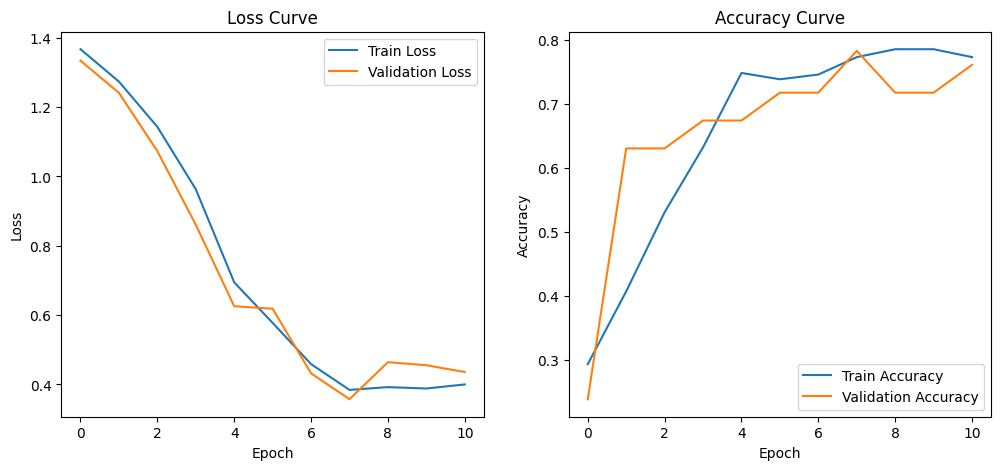

In [ ]:
# ================================
# Imports
# ================================
import numpy as np
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
import matplotlib.pyplot as plt

# ================================
# Predict on test data
# ================================
y_pred_probs = model.predict(X_test)
y_pred_classes = np.argmax(y_pred_probs, axis=1)
y_true_classes = np.argmax(y_test, axis=1)

# ================================
# Compute Test Metrics
# ================================
accuracy = accuracy_score(y_true_classes, y_pred_classes)
precision = precision_score(y_true_classes, y_pred_classes, average='weighted', zero_division=0)
recall = recall_score(y_true_classes, y_pred_classes, average='weighted', zero_division=0)
f1 = f1_score(y_true_classes, y_pred_classes, average='weighted', zero_division=0)

# Loss and Accuracy on test set
test_loss, test_accuracy = model.evaluate(X_test, y_test, verbose=0)

# ================================
# Print Metrics
# ================================
print("=== Test Metrics ===")
print("Test Loss       :", round(test_loss, 4))
print("Test Accuracy   :", round(test_accuracy, 4))
print("Accuracy        :", round(accuracy, 4))
print("Precision       :", round(precision, 4))
print("Recall          :", round(recall, 4))
print("F1-Score        :", round(f1, 4))

# ================================
# Training Metrics from history
# ================================
print("\n=== Training Metrics ===")
print("Final Training Loss    :", round(history.history['loss'][-1], 4))
print("Final Training Accuracy:", round(history.history['accuracy'][-1], 4))
print("Final Validation Loss  :", round(history.history['val_loss'][-1], 4))
print("Final Validation Accuracy:", round(history.history['val_accuracy'][-1], 4))

# ================================
# Optional: Plot Training vs Validation Curves
# ================================
plt.figure(figsize=(12,5))

# Loss curve
plt.subplot(1,2,1)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Loss Curve')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

# Accuracy curve
plt.subplot(1,2,2)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Accuracy Curve')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()



In [ ]:
from sklearn.metrics import confusion_matrix
import pandas as pd
import numpy as np

# -----------------------------
# Assume binary classification: 1 = Positive, 0 = Negative
# If multi-class, you can map your labels to positive/negative first
# -----------------------------
# Example: using 'happy' and 'sad' as Positive, 'angry' and 'fear' as Negative
positive_classes = [1]  # adjust based on your mapping
negative_classes = [0]  # adjust based on your mapping

# Predict classes
y_pred_classes = np.argmax(model.predict(X_test), axis=1)
y_true_classes = np.argmax(y_test, axis=1)

# Map to binary
y_true_binary = np.where(y_true_classes == 1, 1, 0)  # Positive=1, Negative=0
y_pred_binary = np.where(y_pred_classes == 1, 1, 0)

# Compute confusion matrix
cm = confusion_matrix(y_true_binary, y_pred_binary)

# Convert to DataFrame
cm_df = pd.DataFrame(
    cm,
    index=["Actual Positive", "Actual Negative"],
    columns=["Predicted Positive", "Predicted Negative"]
)

print("\nBinary Confusion Matrix:")
print(cm_df)


4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step

Binary Confusion Matrix:
                 Predicted Positive  Predicted Negative
Actual Positive                  80                   0
Actual Negative                   0                  33


4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
Binary Confusion Matrix:

                 Predicted Negative  Predicted Positive
Actual Negative                  80                   0
Actual Positive                   0                  33

Classification Report:

              precision    recall  f1-score   support

    Negative       1.00      1.00      1.00        80
    Positive       1.00      1.00      1.00        33

    accuracy                           1.00       113
   macro avg       1.00      1.00      1.00       113
weighted avg       1.00      1.00      1.00       113



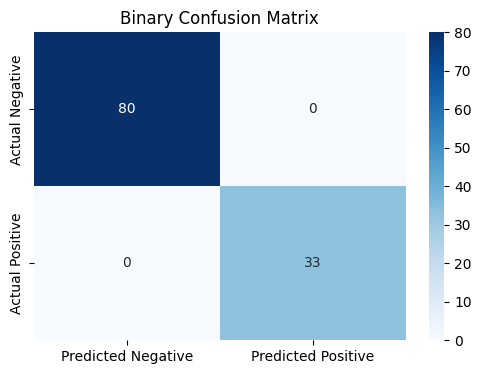

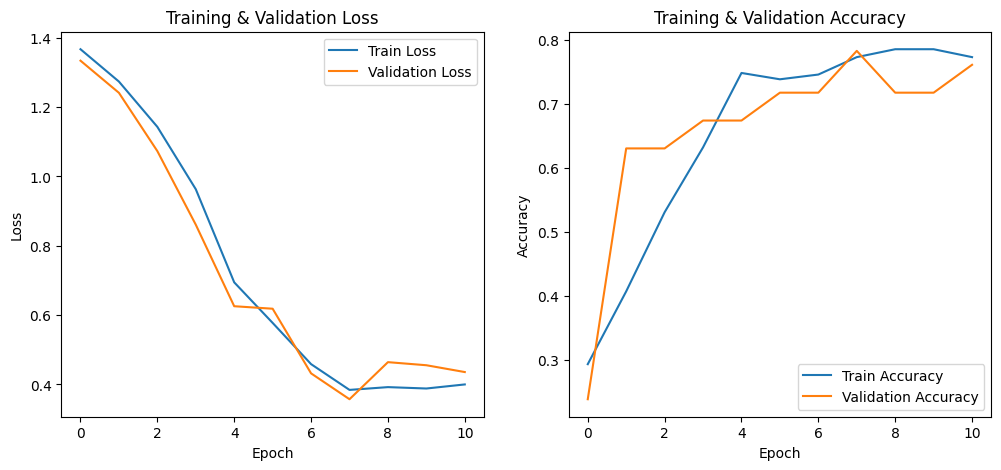

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, classification_report

# -------------------------------
# Assume X_test, y_test, model exist
# -------------------------------

# Get class indices from one-hot vectors
y_true_classes = np.argmax(y_test, axis=1)
y_pred_classes = np.argmax(model.predict(X_test), axis=1)

# Map classes to binary: Positive = 'happy', Negative = others
positive_class = 1  # happy
y_true_binary = np.where(y_true_classes == positive_class, 1, 0)
y_pred_binary = np.where(y_pred_classes == positive_class, 1, 0)

# Confusion Matrix
cm = confusion_matrix(y_true_binary, y_pred_binary)
cm_df = pd.DataFrame(cm, index=['Actual Negative','Actual Positive'],
                     columns=['Predicted Negative','Predicted Positive'])

print("Binary Confusion Matrix:\n")
print(cm_df)

# -------------------------------
# Classification Report (Precision, Recall, F1)
# -------------------------------
print("\nClassification Report:\n")
print(classification_report(y_true_binary, y_pred_binary, target_names=['Negative','Positive']))

# -------------------------------
# Plot Heatmap of Confusion Matrix
# -------------------------------
plt.figure(figsize=(6,4))
sns.heatmap(cm_df, annot=True, fmt='d', cmap='Blues')
plt.title('Binary Confusion Matrix')
plt.show()

# -------------------------------
# Training History Visualization
# -------------------------------
history_dict = model.history.history  # If model was trained with history object
plt.figure(figsize=(12,5))

# Loss
plt.subplot(1,2,1)
plt.plot(history_dict['loss'], label='Train Loss')
plt.plot(history_dict['val_loss'], label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training & Validation Loss')
plt.legend()

# Accuracy
plt.subplot(1,2,2)
plt.plot(history_dict['accuracy'], label='Train Accuracy')
plt.plot(history_dict['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Training & Validation Accuracy')
plt.legend()

plt.show()


4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
Multi-class Confusion Matrix:

              Predicted angry  Predicted happy  Predicted sad  Predicted fear
Actual angry               29                0              1               5
Actual happy                0               33              0               0
Actual sad                  0                0             21               0
Actual fear                12                0              0              12

Classification Report:

              precision    recall  f1-score   support

       angry       0.71      0.83      0.76        35
       happy       1.00      1.00      1.00        33
         sad       0.95      1.00      0.98        21
        fear       0.71      0.50      0.59        24

    accuracy                           0.84       113
   macro avg       0.84      0.83      0.83       113
weighted avg       0.84      0.84      0.83       113



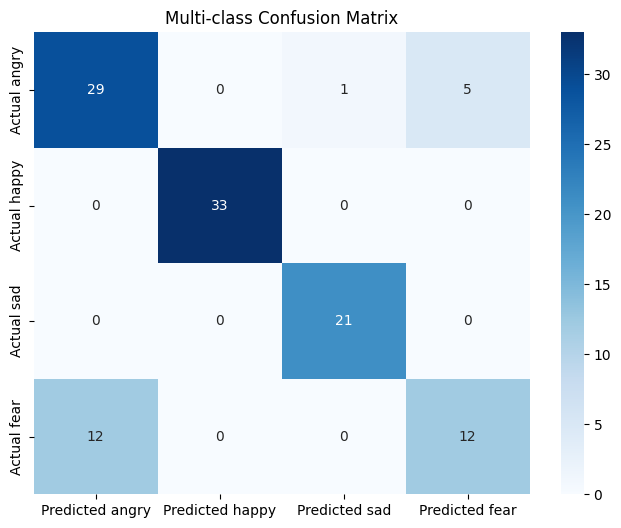

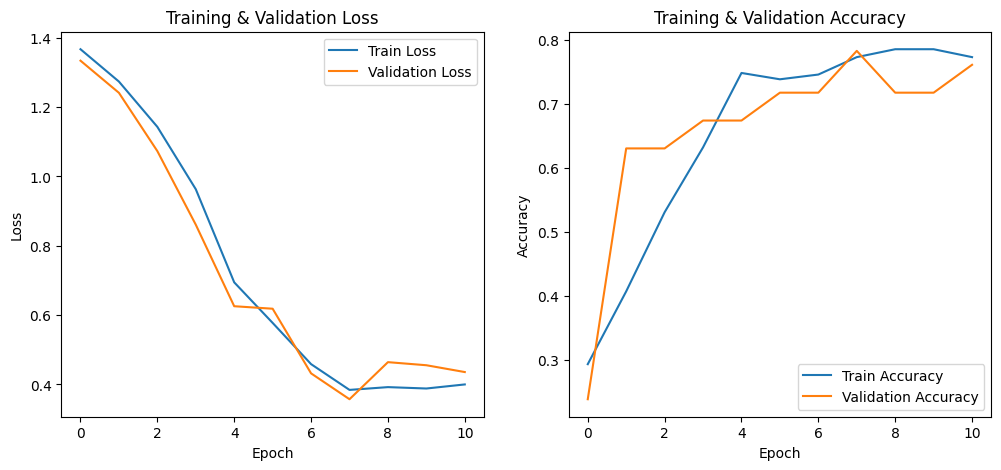

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, classification_report

# -------------------------------
# Predict classes on X_test
# -------------------------------
y_true_classes = np.argmax(y_test, axis=1)
y_pred_classes = np.argmax(model.predict(X_test), axis=1)

# -------------------------------
# Define emotion labels
# -------------------------------
emotion_labels = ['angry', 'happy', 'sad', 'fear']

# -------------------------------
# Multi-class Confusion Matrix
# -------------------------------
cm = confusion_matrix(y_true_classes, y_pred_classes)
cm_df = pd.DataFrame(cm, index=[f'Actual {e}' for e in emotion_labels],
                     columns=[f'Predicted {e}' for e in emotion_labels])

print("Multi-class Confusion Matrix:\n")
print(cm_df)

# -------------------------------
# Classification Report (Precision, Recall, F1)
# -------------------------------
print("\nClassification Report:\n")
print(classification_report(y_true_classes, y_pred_classes, target_names=emotion_labels))

# -------------------------------
# Plot Heatmap of Confusion Matrix
# -------------------------------
plt.figure(figsize=(8,6))
sns.heatmap(cm_df, annot=True, fmt='d', cmap='Blues')
plt.title('Multi-class Confusion Matrix')
plt.show()

# -------------------------------
# Training History Visualization
# -------------------------------
history_dict = model.history.history  # Make sure model was trained with history object
plt.figure(figsize=(12,5))

# Loss
plt.subplot(1,2,1)
plt.plot(history_dict['loss'], label='Train Loss')
plt.plot(history_dict['val_loss'], label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training & Validation Loss')
plt.legend()

# Accuracy
plt.subplot(1,2,2)
plt.plot(history_dict['accuracy'], label='Train Accuracy')
plt.plot(history_dict['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Training & Validation Accuracy')
plt.legend()

plt.show()


Epoch 1/20


/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/embedding.py:97: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


13/13 ━━━━━━━━━━━━━━━━━━━━ 12s 241ms/step - accuracy: 0.3080 - loss: 1.3821 - val_accuracy: 0.5000 - val_loss: 1.3737
Epoch 2/20
13/13 ━━━━━━━━━━━━━━━━━━━━ 5s 255ms/step - accuracy: 0.3133 - loss: 1.3733 - val_accuracy: 0.3043 - val_loss: 1.3629
Epoch 3/20
13/13 ━━━━━━━━━━━━━━━━━━━━ 2s 173ms/step - accuracy: 0.3632 - loss: 1.3577 - val_accuracy: 0.2609 - val_loss: 1.3484
Epoch 4/20
13/13 ━━━━━━━━━━━━━━━━━━━━ 2s 145ms/step - accuracy: 0.4103 - loss: 1.3445 - val_accuracy: 0.3043 - val_loss: 1.3291
Epoch 5/20
13/13 ━━━━━━━━━━━━━━━━━━━━ 2s 79ms/step - accuracy: 0.4543 - loss: 1.3153 - val_accuracy: 0.3261 - val_loss: 1.3036
Epoch 6/20
13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 79ms/step - accuracy: 0.4073 - loss: 1.2918 - val_accuracy: 0.3478 - val_loss: 1.2670
Epoch 7/20
13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 78ms/step - accuracy: 0.4558 - loss: 1.2472 - val_accuracy: 0.3696 - val_loss: 1.2265
Epoch 8/20
13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 77ms/step - accuracy: 0.5057 - loss: 1.1841 - val_accuracy: 0.6739 - val_los

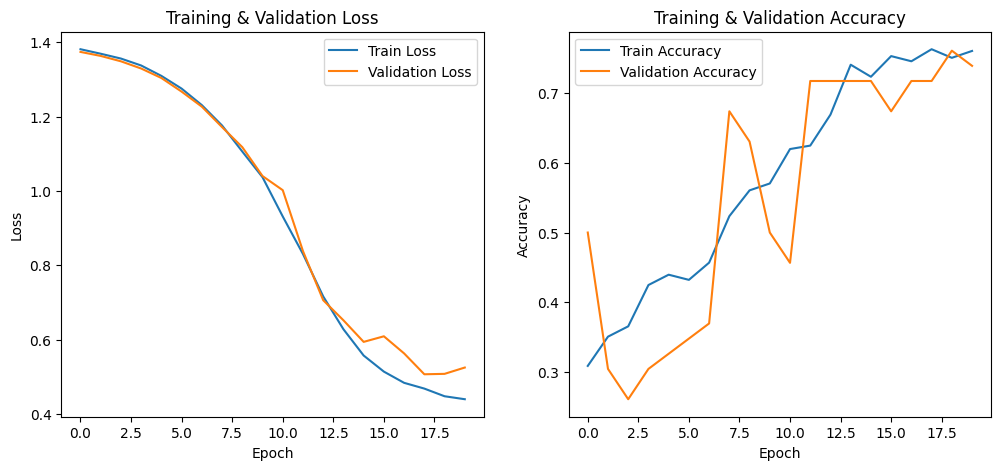

In [ ]:
import matplotlib.pyplot as plt
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense, Dropout, Bidirectional
from tensorflow.keras.optimizers import Adam

# ===============================
# Model Definition
# ===============================
model = Sequential()
model.add(Embedding(input_dim=MAX_NUM_WORDS, output_dim=128, input_length=MAX_SEQUENCE_LENGTH))
model.add(Bidirectional(LSTM(128, return_sequences=False)))
model.add(Dropout(0.5))
model.add(Dense(64, activation='relu'))
model.add(Dense(len(all_emotions), activation='softmax'))

# Compile with **lower learning rate**
optimizer = Adam(learning_rate=0.0001)  # decreased from 0.0005
model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])

# ===============================
# Train the Model
# ===============================
history = model.fit(
    X_train, y_train,
    epochs=20,
    batch_size=32,
    validation_split=0.1,
    shuffle=True
)

# ===============================
# Plot Training & Validation Curves
# ===============================
plt.figure(figsize=(12,5))

# Loss curve
plt.subplot(1,2,1)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Training & Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

# Accuracy curve
plt.subplot(1,2,2)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Training & Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.show()


Epoch 1/20
13/13 ━━━━━━━━━━━━━━━━━━━━ 9s 142ms/step - accuracy: 0.3562 - loss: 1.3746 - val_accuracy: 0.5652 - val_loss: 1.3316
Epoch 2/20
13/13 ━━━━━━━━━━━━━━━━━━━━ 2s 122ms/step - accuracy: 0.5822 - loss: 1.3004 - val_accuracy: 0.7174 - val_loss: 1.1732
Epoch 3/20
13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 77ms/step - accuracy: 0.5986 - loss: 1.0775 - val_accuracy: 0.7174 - val_loss: 0.9204
Epoch 4/20
13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 77ms/step - accuracy: 0.6161 - loss: 0.8167 - val_accuracy: 0.8478 - val_loss: 0.8729
Epoch 5/20
13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 78ms/step - accuracy: 0.6605 - loss: 0.6910 - val_accuracy: 0.7174 - val_loss: 0.6210
Epoch 6/20
13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 79ms/step - accuracy: 0.7992 - loss: 0.5361 - val_accuracy: 0.7391 - val_loss: 0.5276
Epoch 7/20
13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 83ms/step - accuracy: 0.8499 - loss: 0.3593 - val_accuracy: 0.7391 - val_loss: 0.4501
Epoch 8/20
13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 77ms/step - accuracy: 0.8124 - loss: 0.3579 - val_accuracy: 0.7609 -

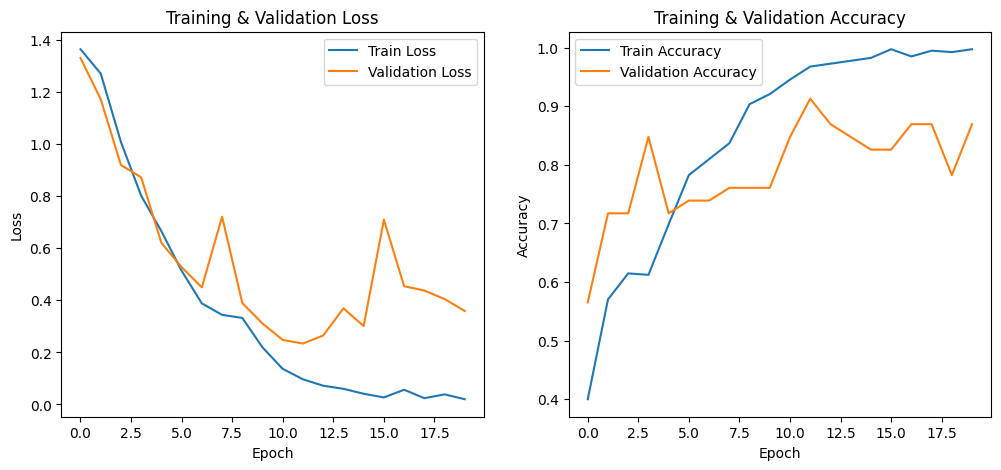

In [ ]:
import matplotlib.pyplot as plt
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense, Dropout, Bidirectional
from tensorflow.keras.optimizers import Adam

# ===============================
# Model Definition
# ===============================
model = Sequential()
model.add(Embedding(input_dim=MAX_NUM_WORDS, output_dim=128, input_length=MAX_SEQUENCE_LENGTH))
model.add(Bidirectional(LSTM(128, return_sequences=False)))
model.add(Dropout(0.5))
model.add(Dense(64, activation='relu'))
model.add(Dense(len(all_emotions), activation='softmax'))

# Compile with **lower learning rate**
optimizer = Adam(learning_rate=0.0005)
model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])

# ===============================
# Train the Model
# ===============================
history = model.fit(
    X_train, y_train,
    epochs=20,
    batch_size=32,
    validation_split=0.1,
    shuffle=True
)

# ===============================
# Plot Training & Validation Curves
# ===============================
plt.figure(figsize=(12,5))

# Loss curve
plt.subplot(1,2,1)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Training & Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

# Accuracy curve
plt.subplot(1,2,2)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Training & Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.show()


Epoch 1/20
13/13 ━━━━━━━━━━━━━━━━━━━━ 6s 118ms/step - accuracy: 0.3339 - loss: 1.3650 - val_accuracy: 0.3478 - val_loss: 1.2355
Epoch 2/20
13/13 ━━━━━━━━━━━━━━━━━━━━ 2s 143ms/step - accuracy: 0.5047 - loss: 1.1131 - val_accuracy: 0.6739 - val_loss: 0.9245
Epoch 3/20
13/13 ━━━━━━━━━━━━━━━━━━━━ 2s 130ms/step - accuracy: 0.6929 - loss: 0.7229 - val_accuracy: 0.7391 - val_loss: 0.6006
Epoch 4/20
13/13 ━━━━━━━━━━━━━━━━━━━━ 2s 79ms/step - accuracy: 0.8054 - loss: 0.4924 - val_accuracy: 0.7174 - val_loss: 0.4797
Epoch 5/20
13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 78ms/step - accuracy: 0.7776 - loss: 0.3855 - val_accuracy: 0.8478 - val_loss: 0.3715
Epoch 6/20
13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 80ms/step - accuracy: 0.8714 - loss: 0.2971 - val_accuracy: 0.8261 - val_loss: 0.3586
Epoch 7/20
13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 80ms/step - accuracy: 0.9299 - loss: 0.1646 - val_accuracy: 0.8478 - val_loss: 0.5018
Epoch 8/20
13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 77ms/step - accuracy: 0.9692 - loss: 0.0783 - val_accuracy: 0.8478 

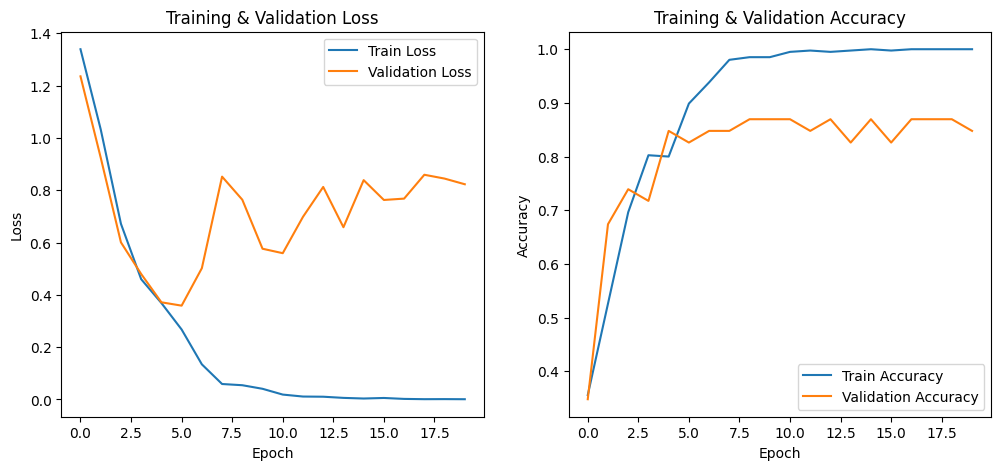

In [ ]:
import matplotlib.pyplot as plt
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense, Dropout, Bidirectional
from tensorflow.keras.optimizers import Adam

# ===============================
# Model Definition
# ===============================
model = Sequential()
model.add(Embedding(input_dim=MAX_NUM_WORDS, output_dim=128, input_length=MAX_SEQUENCE_LENGTH))
model.add(Bidirectional(LSTM(128, return_sequences=False)))
model.add(Dropout(0.5))
model.add(Dense(64, activation='relu'))
model.add(Dense(len(all_emotions), activation='softmax'))

# Compile with **higher learning rate**
optimizer = Adam(learning_rate=0.001)  # increased from 0.0005
model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])

# ===============================
# Train the Model
# ===============================
history = model.fit(
    X_train, y_train,
    epochs=20,
    batch_size=32,
    validation_split=0.1,
    shuffle=True
)

# ===============================
# Plot Training & Validation Curves
# ===============================
plt.figure(figsize=(12,5))

# Loss curve
plt.subplot(1,2,1)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Training & Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

# Accuracy curve
plt.subplot(1,2,2)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Training & Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.show()


Epoch 1/20
51/51 ━━━━━━━━━━━━━━━━━━━━ 15s 51ms/step - accuracy: 0.3425 - loss: 1.3487 - val_accuracy: 0.4348 - val_loss: 1.1338
Epoch 2/20
51/51 ━━━━━━━━━━━━━━━━━━━━ 5s 40ms/step - accuracy: 0.5505 - loss: 0.9660 - val_accuracy: 0.6739 - val_loss: 0.8760
Epoch 3/20
51/51 ━━━━━━━━━━━━━━━━━━━━ 3s 54ms/step - accuracy: 0.7507 - loss: 0.5483 - val_accuracy: 0.6957 - val_loss: 0.5383
Epoch 4/20
51/51 ━━━━━━━━━━━━━━━━━━━━ 6s 64ms/step - accuracy: 0.8310 - loss: 0.4109 - val_accuracy: 0.7174 - val_loss: 0.6705
Epoch 5/20
51/51 ━━━━━━━━━━━━━━━━━━━━ 2s 40ms/step - accuracy: 0.8195 - loss: 0.3846 - val_accuracy: 0.8696 - val_loss: 0.3923
Epoch 6/20
51/51 ━━━━━━━━━━━━━━━━━━━━ 2s 39ms/step - accuracy: 0.9280 - loss: 0.1996 - val_accuracy: 0.8261 - val_loss: 0.4350
Epoch 7/20
51/51 ━━━━━━━━━━━━━━━━━━━━ 3s 53ms/step - accuracy: 0.9721 - loss: 0.0717 - val_accuracy: 0.8478 - val_loss: 0.3898
Epoch 8/20
51/51 ━━━━━━━━━━━━━━━━━━━━ 3s 50ms/step - accuracy: 0.9793 - loss: 0.0523 - val_accuracy: 0.8478 - 

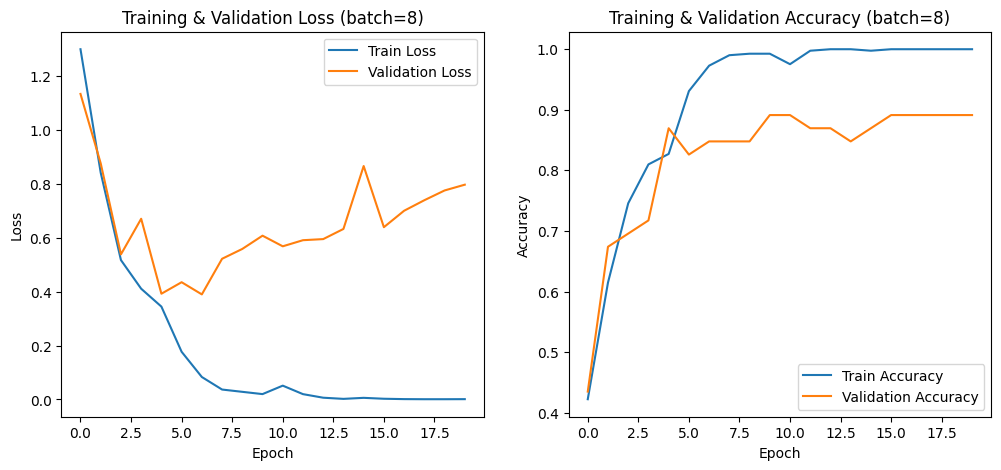

In [ ]:
import matplotlib.pyplot as plt
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense, Dropout, Bidirectional
from tensorflow.keras.optimizers import Adam

# ===============================
# Model Definition
# ===============================
model = Sequential()
model.add(Embedding(input_dim=MAX_NUM_WORDS, output_dim=128, input_length=MAX_SEQUENCE_LENGTH))
model.add(Bidirectional(LSTM(128, return_sequences=False)))
model.add(Dropout(0.5))
model.add(Dense(64, activation='relu'))
model.add(Dense(len(all_emotions), activation='softmax'))

# Compile with lower learning rate
optimizer = Adam(learning_rate=0.0005)
model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])

# ===============================
# Train the Model with batch size = 8
# ===============================
history = model.fit(
    X_train, y_train,
    epochs=20,
    batch_size=8,   # 🔹 smaller batch size
    validation_split=0.1,
    shuffle=True
)

# ===============================
# Plot Training & Validation Curves
# ===============================
plt.figure(figsize=(12,5))

# Loss curve
plt.subplot(1,2,1)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Training & Validation Loss (batch=8)')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

# Accuracy curve
plt.subplot(1,2,2)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Training & Validation Accuracy (batch=8)')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.show()


Epoch 1/20
26/26 ━━━━━━━━━━━━━━━━━━━━ 7s 72ms/step - accuracy: 0.3285 - loss: 1.3614 - val_accuracy: 0.5870 - val_loss: 1.2555
Epoch 2/20
26/26 ━━━━━━━━━━━━━━━━━━━━ 2s 68ms/step - accuracy: 0.5581 - loss: 1.1788 - val_accuracy: 0.6957 - val_loss: 0.8689
Epoch 3/20
26/26 ━━━━━━━━━━━━━━━━━━━━ 1s 44ms/step - accuracy: 0.6935 - loss: 0.7286 - val_accuracy: 0.7174 - val_loss: 0.5872
Epoch 4/20
26/26 ━━━━━━━━━━━━━━━━━━━━ 1s 45ms/step - accuracy: 0.7650 - loss: 0.4402 - val_accuracy: 0.6739 - val_loss: 0.4694
Epoch 5/20
26/26 ━━━━━━━━━━━━━━━━━━━━ 1s 46ms/step - accuracy: 0.7615 - loss: 0.4070 - val_accuracy: 0.6739 - val_loss: 0.5239
Epoch 6/20
26/26 ━━━━━━━━━━━━━━━━━━━━ 1s 43ms/step - accuracy: 0.7775 - loss: 0.3570 - val_accuracy: 0.7609 - val_loss: 0.3910
Epoch 7/20
26/26 ━━━━━━━━━━━━━━━━━━━━ 1s 45ms/step - accuracy: 0.8359 - loss: 0.3273 - val_accuracy: 0.8696 - val_loss: 0.3985
Epoch 8/20
26/26 ━━━━━━━━━━━━━━━━━━━━ 1s 45ms/step - accuracy: 0.8967 - loss: 0.2554 - val_accuracy: 0.8478 - v

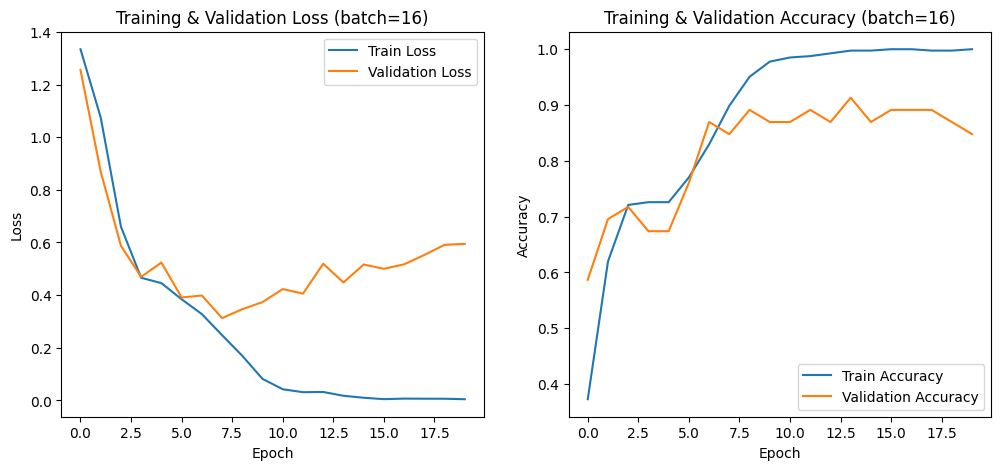

In [ ]:
import matplotlib.pyplot as plt
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense, Dropout, Bidirectional
from tensorflow.keras.optimizers import Adam

# ===============================
# Model Definition
# ===============================
model = Sequential()
model.add(Embedding(input_dim=MAX_NUM_WORDS, output_dim=128, input_length=MAX_SEQUENCE_LENGTH))
model.add(Bidirectional(LSTM(128, return_sequences=False)))
model.add(Dropout(0.5))
model.add(Dense(64, activation='relu'))
model.add(Dense(len(all_emotions), activation='softmax'))

# Compile with lower learning rate
optimizer = Adam(learning_rate=0.0005)
model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])

# ===============================
# Train the Model with batch size = 16
# ===============================
history = model.fit(
    X_train, y_train,
    epochs=20,
    batch_size=16,   # 🔹 updated batch size
    validation_split=0.1,
    shuffle=True
)

# ===============================
# Plot Training & Validation Curves
# ===============================
plt.figure(figsize=(12,5))

# Loss curve
plt.subplot(1,2,1)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Training & Validation Loss (batch=16)')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

# Accuracy curve
plt.subplot(1,2,2)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Training & Validation Accuracy (batch=16)')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.show()


Epoch 1/20
13/13 ━━━━━━━━━━━━━━━━━━━━ 6s 120ms/step - accuracy: 0.3166 - loss: 1.3701 - val_accuracy: 0.5435 - val_loss: 1.3187
Epoch 2/20
13/13 ━━━━━━━━━━━━━━━━━━━━ 2s 123ms/step - accuracy: 0.3164 - loss: 1.3035 - val_accuracy: 0.5870 - val_loss: 1.2075
Epoch 3/20
13/13 ━━━━━━━━━━━━━━━━━━━━ 2s 148ms/step - accuracy: 0.5761 - loss: 1.1053 - val_accuracy: 0.4783 - val_loss: 0.9944
Epoch 4/20
13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 78ms/step - accuracy: 0.6145 - loss: 0.8375 - val_accuracy: 0.7174 - val_loss: 0.7028
Epoch 5/20
13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 77ms/step - accuracy: 0.7243 - loss: 0.5854 - val_accuracy: 0.7174 - val_loss: 1.0085
Epoch 6/20
13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 76ms/step - accuracy: 0.7303 - loss: 0.6107 - val_accuracy: 0.7609 - val_loss: 0.4930
Epoch 7/20
13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 80ms/step - accuracy: 0.7505 - loss: 0.4314 - val_accuracy: 0.7174 - val_loss: 0.4867
Epoch 8/20
13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 78ms/step - accuracy: 0.8104 - loss: 0.3755 - val_accuracy: 0.8696 

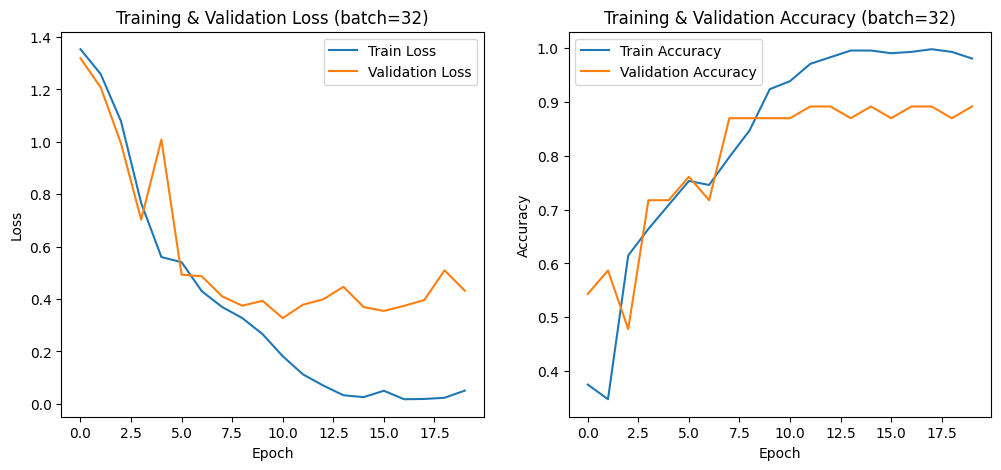

In [ ]:
import matplotlib.pyplot as plt
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense, Dropout, Bidirectional
from tensorflow.keras.optimizers import Adam

# ===============================
# Model Definition
# ===============================
model = Sequential()
model.add(Embedding(input_dim=MAX_NUM_WORDS, output_dim=128, input_length=MAX_SEQUENCE_LENGTH))
model.add(Bidirectional(LSTM(128, return_sequences=False)))
model.add(Dropout(0.5))
model.add(Dense(64, activation='relu'))
model.add(Dense(len(all_emotions), activation='softmax'))

# Compile with lower learning rate
optimizer = Adam(learning_rate=0.0005)
model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])

# ===============================
# Train the Model with batch size = 32
# ===============================
history = model.fit(
    X_train, y_train,
    epochs=20,
    batch_size=32,   # 🔹 updated batch size
    validation_split=0.1,
    shuffle=True
)

# ===============================
# Plot Training & Validation Curves
# ===============================
plt.figure(figsize=(12,5))

# Loss curve
plt.subplot(1,2,1)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Training & Validation Loss (batch=32)')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

# Accuracy curve
plt.subplot(1,2,2)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Training & Validation Accuracy (batch=32)')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.show()


Epoch 1/20
7/7 ━━━━━━━━━━━━━━━━━━━━ 6s 187ms/step - accuracy: 0.2949 - loss: 1.3778 - val_accuracy: 0.2826 - val_loss: 1.3489
Epoch 2/20
7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 103ms/step - accuracy: 0.3551 - loss: 1.3309 - val_accuracy: 0.3478 - val_loss: 1.2886
Epoch 3/20
7/7 ━━━━━━━━━━━━━━━━━━━━ 2s 161ms/step - accuracy: 0.3992 - loss: 1.2587 - val_accuracy: 0.3913 - val_loss: 1.2053
Epoch 4/20
7/7 ━━━━━━━━━━━━━━━━━━━━ 2s 197ms/step - accuracy: 0.4861 - loss: 1.1503 - val_accuracy: 0.4348 - val_loss: 1.0738
Epoch 5/20
7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 152ms/step - accuracy: 0.5501 - loss: 1.0172 - val_accuracy: 0.6739 - val_loss: 1.0063
Epoch 6/20
7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 102ms/step - accuracy: 0.6398 - loss: 0.8196 - val_accuracy: 0.6087 - val_loss: 0.9094
Epoch 7/20
7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 100ms/step - accuracy: 0.6854 - loss: 0.7438 - val_accuracy: 0.7391 - val_loss: 0.7026
Epoch 8/20
7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 105ms/step - accuracy: 0.7162 - loss: 0.6467 - val_accuracy: 0.6957 - val_loss:

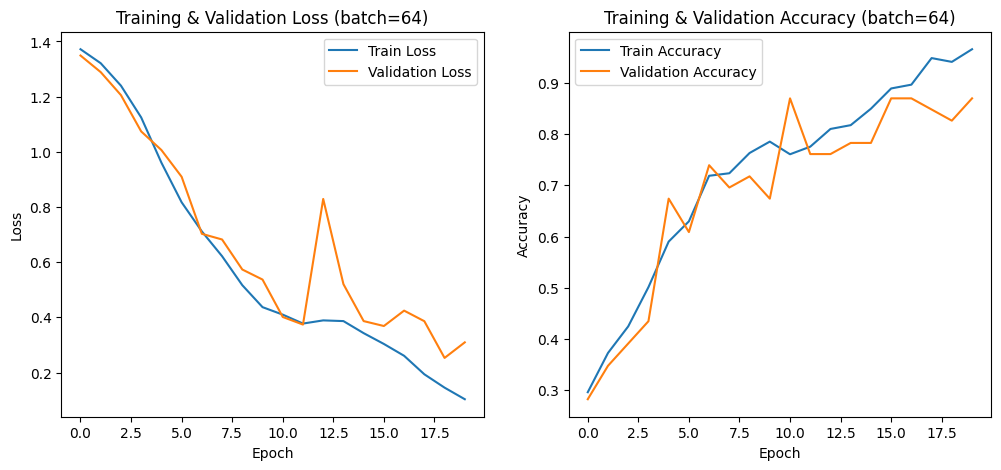

In [ ]:
import matplotlib.pyplot as plt
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense, Dropout, Bidirectional
from tensorflow.keras.optimizers import Adam

# ===============================
# Model Definition
# ===============================
model = Sequential()
model.add(Embedding(input_dim=MAX_NUM_WORDS, output_dim=128, input_length=MAX_SEQUENCE_LENGTH))
model.add(Bidirectional(LSTM(128, return_sequences=False)))
model.add(Dropout(0.5))
model.add(Dense(64, activation='relu'))
model.add(Dense(len(all_emotions), activation='softmax'))

# Compile with lower learning rate
optimizer = Adam(learning_rate=0.0005)
model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])

# ===============================
# Train the Model with batch size = 64
# ===============================
history = model.fit(
    X_train, y_train,
    epochs=20,
    batch_size=64,   # 🔹 updated batch size
    validation_split=0.1,
    shuffle=True
)

# ===============================
# Plot Training & Validation Curves
# ===============================
plt.figure(figsize=(12,5))

# Loss curve
plt.subplot(1,2,1)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Training & Validation Loss (batch=64)')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

# Accuracy curve
plt.subplot(1,2,2)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Training & Validation Accuracy (batch=64)')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.show()


Epoch 1/50
7/7 ━━━━━━━━━━━━━━━━━━━━ 7s 201ms/step - accuracy: 0.2802 - loss: 1.3798 - val_accuracy: 0.3261 - val_loss: 1.3510
Epoch 2/50
7/7 ━━━━━━━━━━━━━━━━━━━━ 2s 114ms/step - accuracy: 0.3944 - loss: 1.3347 - val_accuracy: 0.3261 - val_loss: 1.2979
Epoch 3/50
7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 111ms/step - accuracy: 0.3484 - loss: 1.2659 - val_accuracy: 0.3478 - val_loss: 1.2192
Epoch 4/50
7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 142ms/step - accuracy: 0.4481 - loss: 1.1373 - val_accuracy: 0.6739 - val_loss: 1.0728
Epoch 5/50
7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 211ms/step - accuracy: 0.6132 - loss: 1.0130 - val_accuracy: 0.7174 - val_loss: 0.9366
Epoch 6/50
7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 184ms/step - accuracy: 0.6359 - loss: 0.8700 - val_accuracy: 0.6739 - val_loss: 0.8685
Epoch 7/50
7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 107ms/step - accuracy: 0.7278 - loss: 0.6902 - val_accuracy: 0.7609 - val_loss: 0.6457
Epoch 8/50
7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 112ms/step - accuracy: 0.8011 - loss: 0.5431 - val_accuracy: 0.7609 - val_loss:

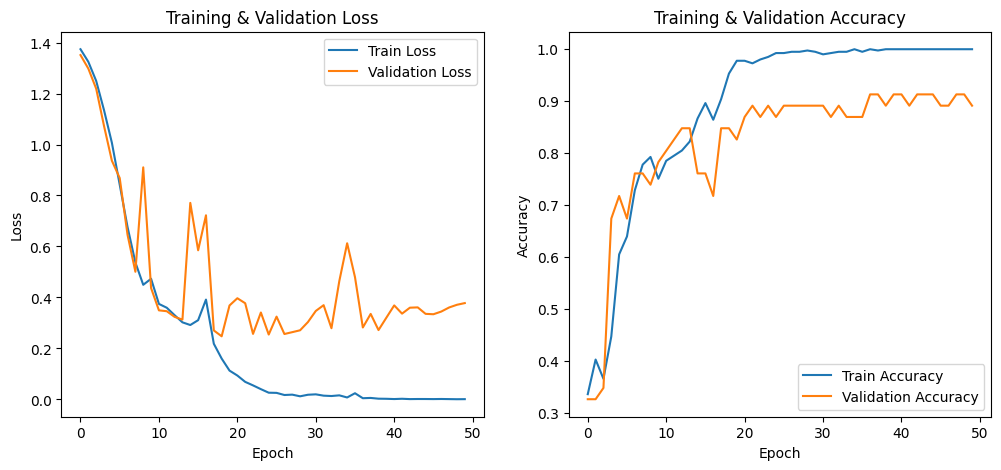

In [ ]:
import matplotlib.pyplot as plt
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense, Dropout, Bidirectional
from tensorflow.keras.optimizers import Adam

# ===============================
# Model Definition
# ===============================
model = Sequential()
model.add(Embedding(input_dim=MAX_NUM_WORDS, output_dim=128, input_length=MAX_SEQUENCE_LENGTH))
model.add(Bidirectional(LSTM(128, return_sequences=False)))
model.add(Dropout(0.5))
model.add(Dense(64, activation='relu'))
model.add(Dense(len(all_emotions), activation='softmax'))

# Compile with lower learning rate
optimizer = Adam(learning_rate=0.0005)
model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])

# ===============================
# Train the Model with increased epochs
# ===============================
history = model.fit(
    X_train, y_train,
    epochs=50,      # 🔹 increased number of epochs
    batch_size=64,  # or any batch size you want
    validation_split=0.1,
    shuffle=True
)

# ===============================
# Plot Training & Validation Curves
# ===============================
plt.figure(figsize=(12,5))

# Loss curve
plt.subplot(1,2,1)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Training & Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

# Accuracy curve
plt.subplot(1,2,2)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Training & Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.show()


Epoch 1/20
7/7 ━━━━━━━━━━━━━━━━━━━━ 8s 193ms/step - accuracy: 0.3138 - loss: 1.3828 - val_accuracy: 0.5435 - val_loss: 1.3766
Epoch 2/20
7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 109ms/step - accuracy: 0.3760 - loss: 1.3754 - val_accuracy: 0.5217 - val_loss: 1.3713
Epoch 3/20
7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 107ms/step - accuracy: 0.4125 - loss: 1.3707 - val_accuracy: 0.3913 - val_loss: 1.3653
Epoch 4/20
7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 99ms/step - accuracy: 0.4414 - loss: 1.3643 - val_accuracy: 0.3478 - val_loss: 1.3579
Epoch 5/20
7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 198ms/step - accuracy: 0.5072 - loss: 1.3513 - val_accuracy: 0.3478 - val_loss: 1.3481
Epoch 6/20
7/7 ━━━━━━━━━━━━━━━━━━━━ 2s 217ms/step - accuracy: 0.4676 - loss: 1.3437 - val_accuracy: 0.4783 - val_loss: 1.3357
Epoch 7/20
7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 113ms/step - accuracy: 0.5152 - loss: 1.3251 - val_accuracy: 0.5870 - val_loss: 1.3198
Epoch 8/20
7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 112ms/step - accuracy: 0.5052 - loss: 1.3091 - val_accuracy: 0.6087 - val_loss: 

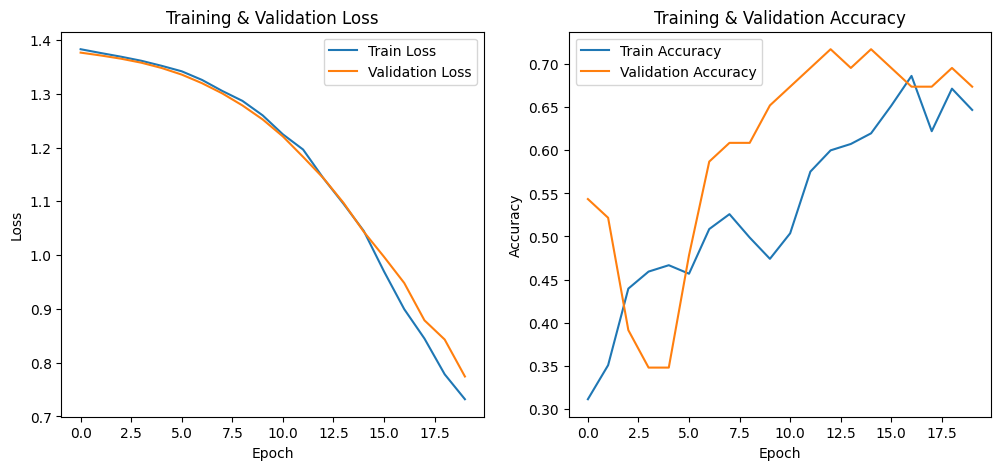

In [ ]:
import matplotlib.pyplot as plt
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense, Dropout, Bidirectional
from tensorflow.keras.optimizers import Adam

# ===============================
# Model Definition
# ===============================
model = Sequential()
model.add(Embedding(input_dim=MAX_NUM_WORDS, output_dim=128, input_length=MAX_SEQUENCE_LENGTH))
model.add(Bidirectional(LSTM(128, return_sequences=False)))
model.add(Dropout(0.5))
model.add(Dense(64, activation='relu'))
model.add(Dense(len(all_emotions), activation='softmax'))

# Compile with lower learning rate
optimizer = Adam(learning_rate=0.0001)
model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])

# ===============================
# Train the Model with increased epochs
# ===============================
history = model.fit(
    X_train, y_train,
    epochs=20,
    batch_size=64,  # or any batch size you want
    validation_split=0.1,
    shuffle=True
)

# ===============================
# Plot Training & Validation Curves
# ===============================
plt.figure(figsize=(12,5))

# Loss curve
plt.subplot(1,2,1)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Training & Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

# Accuracy curve
plt.subplot(1,2,2)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Training & Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.show()


Epoch 1/10
7/7 ━━━━━━━━━━━━━━━━━━━━ 6s 260ms/step - accuracy: 0.2558 - loss: 1.3867 - val_accuracy: 0.4565 - val_loss: 1.3798
Epoch 2/10
7/7 ━━━━━━━━━━━━━━━━━━━━ 2s 116ms/step - accuracy: 0.3619 - loss: 1.3792 - val_accuracy: 0.4348 - val_loss: 1.3745
Epoch 3/10
7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 104ms/step - accuracy: 0.4526 - loss: 1.3748 - val_accuracy: 0.4565 - val_loss: 1.3684
Epoch 4/10
7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 105ms/step - accuracy: 0.5414 - loss: 1.3658 - val_accuracy: 0.5435 - val_loss: 1.3605
Epoch 5/10
7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 118ms/step - accuracy: 0.5762 - loss: 1.3595 - val_accuracy: 0.5000 - val_loss: 1.3514
Epoch 6/10
7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 109ms/step - accuracy: 0.6148 - loss: 1.3471 - val_accuracy: 0.4783 - val_loss: 1.3402
Epoch 7/10
7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 100ms/step - accuracy: 0.5844 - loss: 1.3362 - val_accuracy: 0.4565 - val_loss: 1.3256
Epoch 8/10
7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 110ms/step - accuracy: 0.5626 - loss: 1.3245 - val_accuracy: 0.4130 - val_loss:

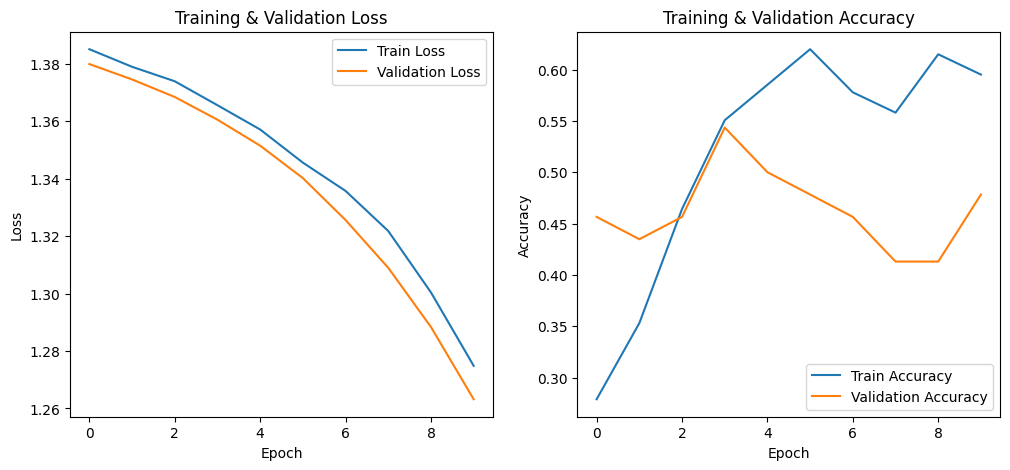

In [ ]:
import matplotlib.pyplot as plt
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense, Dropout, Bidirectional
from tensorflow.keras.optimizers import Adam

# ===============================
# Model Definition
# ===============================
model = Sequential()
model.add(Embedding(input_dim=MAX_NUM_WORDS, output_dim=128, input_length=MAX_SEQUENCE_LENGTH))
model.add(Bidirectional(LSTM(128, return_sequences=False)))
model.add(Dropout(0.5))
model.add(Dense(64, activation='relu'))
model.add(Dense(len(all_emotions), activation='softmax'))

# Compile with lower learning rate
optimizer = Adam(learning_rate=0.0001)
model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])

# ===============================
# Train the Model with increased epochs
# ===============================
history = model.fit(
    X_train, y_train,
    epochs=10,
    batch_size=64,  # or any batch size you want
    validation_split=0.1,
    shuffle=True
)

# ===============================
# Plot Training & Validation Curves
# ===============================
plt.figure(figsize=(12,5))

# Loss curve
plt.subplot(1,2,1)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Training & Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

# Accuracy curve
plt.subplot(1,2,2)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Training & Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.show()


Epoch 1/5
7/7 ━━━━━━━━━━━━━━━━━━━━ 6s 186ms/step - accuracy: 0.2098 - loss: 1.3869 - val_accuracy: 0.2391 - val_loss: 1.3821
Epoch 2/5
7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 99ms/step - accuracy: 0.2861 - loss: 1.3775 - val_accuracy: 0.2391 - val_loss: 1.3743
Epoch 3/5
7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 106ms/step - accuracy: 0.3277 - loss: 1.3723 - val_accuracy: 0.2391 - val_loss: 1.3671
Epoch 4/5
7/7 ━━━━━━━━━━━━━━━━━━━━ 2s 190ms/step - accuracy: 0.3443 - loss: 1.3602 - val_accuracy: 0.2609 - val_loss: 1.3590
Epoch 5/5
7/7 ━━━━━━━━━━━━━━━━━━━━ 2s 123ms/step - accuracy: 0.3385 - loss: 1.3511 - val_accuracy: 0.2609 - val_loss: 1.3491


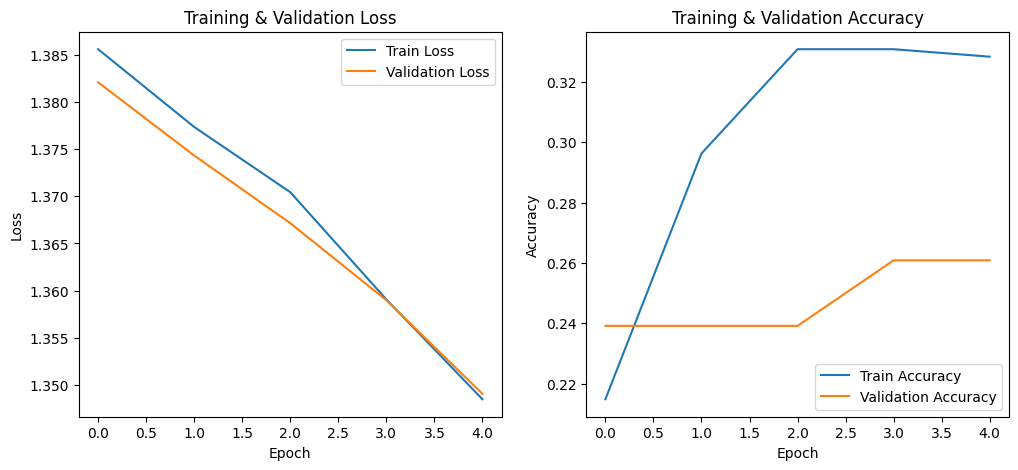

In [ ]:
import matplotlib.pyplot as plt
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense, Dropout, Bidirectional
from tensorflow.keras.optimizers import Adam

# ===============================
# Model Definition
# ===============================
model = Sequential()
model.add(Embedding(input_dim=MAX_NUM_WORDS, output_dim=128, input_length=MAX_SEQUENCE_LENGTH))
model.add(Bidirectional(LSTM(128, return_sequences=False)))
model.add(Dropout(0.5))
model.add(Dense(64, activation='relu'))
model.add(Dense(len(all_emotions), activation='softmax'))

# Compile with lower learning rate
optimizer = Adam(learning_rate=0.0001)
model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])

# ===============================
# Train the Model with increased epochs
# ===============================
history = model.fit(
    X_train, y_train,
    epochs=5,
    batch_size=64,  # or any batch size you want
    validation_split=0.1,
    shuffle=True
)

# ===============================
# Plot Training & Validation Curves
# ===============================
plt.figure(figsize=(12,5))

# Loss curve
plt.subplot(1,2,1)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Training & Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

# Accuracy curve
plt.subplot(1,2,2)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Training & Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.show()


Epoch 1/35
7/7 ━━━━━━━━━━━━━━━━━━━━ 9s 212ms/step - accuracy: 0.2602 - loss: 1.3856 - val_accuracy: 0.4783 - val_loss: 1.3780
Epoch 2/35
7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 110ms/step - accuracy: 0.4698 - loss: 1.3751 - val_accuracy: 0.4348 - val_loss: 1.3702
Epoch 3/35
7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 112ms/step - accuracy: 0.4420 - loss: 1.3656 - val_accuracy: 0.4348 - val_loss: 1.3617
Epoch 4/35
7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 110ms/step - accuracy: 0.4577 - loss: 1.3563 - val_accuracy: 0.4348 - val_loss: 1.3519
Epoch 5/35
7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 108ms/step - accuracy: 0.4933 - loss: 1.3448 - val_accuracy: 0.4565 - val_loss: 1.3394
Epoch 6/35
7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 107ms/step - accuracy: 0.5399 - loss: 1.3301 - val_accuracy: 0.4565 - val_loss: 1.3237
Epoch 7/35
7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 114ms/step - accuracy: 0.5856 - loss: 1.3101 - val_accuracy: 0.4783 - val_loss: 1.3037
Epoch 8/35
7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 105ms/step - accuracy: 0.5634 - loss: 1.2874 - val_accuracy: 0.5870 - val_loss:

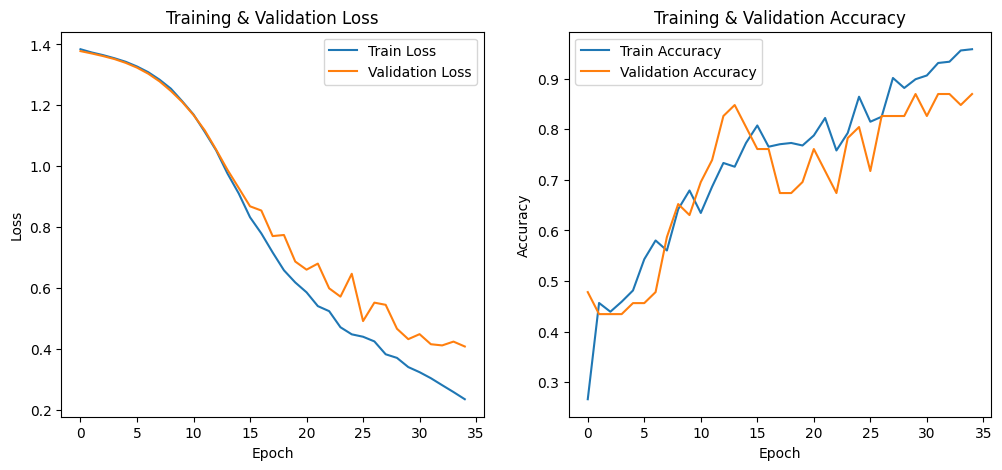

In [ ]:
import matplotlib.pyplot as plt
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense, Dropout, Bidirectional
from tensorflow.keras.optimizers import Adam

# ===============================
# Model Definition
# ===============================
model = Sequential()
model.add(Embedding(input_dim=MAX_NUM_WORDS, output_dim=128, input_length=MAX_SEQUENCE_LENGTH))
model.add(Bidirectional(LSTM(128, return_sequences=False)))
model.add(Dropout(0.1))
model.add(Dense(64, activation='relu'))
model.add(Dense(len(all_emotions), activation='softmax'))

# Compile with lower learning rate
optimizer = Adam(learning_rate=0.0001)
model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])

# ===============================
# Train the Model with increased epochs
# ===============================
history = model.fit(
    X_train, y_train,
    epochs=35,
    batch_size=64,  # or any batch size you want
    validation_split=0.1,
    shuffle=True
)

# ===============================
# Plot Training & Validation Curves
# ===============================
plt.figure(figsize=(12,5))

# Loss curve
plt.subplot(1,2,1)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Training & Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

# Accuracy curve
plt.subplot(1,2,2)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Training & Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.show()


Epoch 1/35
7/7 ━━━━━━━━━━━━━━━━━━━━ 6s 196ms/step - accuracy: 0.3005 - loss: 1.3812 - val_accuracy: 0.5652 - val_loss: 1.3754
Epoch 2/35
7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 227ms/step - accuracy: 0.4100 - loss: 1.3739 - val_accuracy: 0.3478 - val_loss: 1.3683
Epoch 3/35
7/7 ━━━━━━━━━━━━━━━━━━━━ 2s 113ms/step - accuracy: 0.4167 - loss: 1.3708 - val_accuracy: 0.3478 - val_loss: 1.3609
Epoch 4/35
7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 109ms/step - accuracy: 0.4378 - loss: 1.3597 - val_accuracy: 0.2609 - val_loss: 1.3538
Epoch 5/35
7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 102ms/step - accuracy: 0.4239 - loss: 1.3490 - val_accuracy: 0.3043 - val_loss: 1.3453
Epoch 6/35
7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 107ms/step - accuracy: 0.4082 - loss: 1.3407 - val_accuracy: 0.3261 - val_loss: 1.3346
Epoch 7/35
7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 109ms/step - accuracy: 0.4800 - loss: 1.3277 - val_accuracy: 0.5217 - val_loss: 1.3204
Epoch 8/35
7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 111ms/step - accuracy: 0.5224 - loss: 1.3115 - val_accuracy: 0.6522 - val_loss:

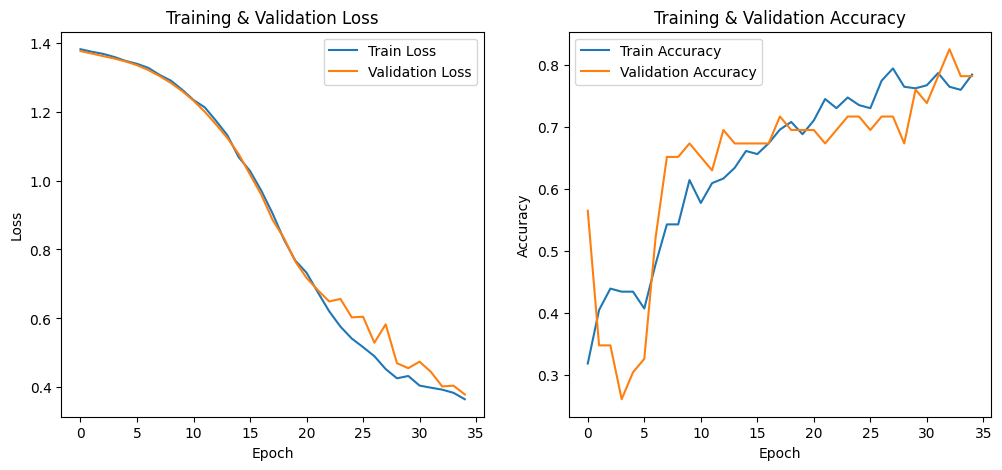

In [ ]:
import matplotlib.pyplot as plt
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense, Dropout, Bidirectional
from tensorflow.keras.optimizers import Adam

# ===============================
# Model Definition
# ===============================
model = Sequential()
model.add(Embedding(input_dim=MAX_NUM_WORDS, output_dim=128, input_length=MAX_SEQUENCE_LENGTH))
model.add(Bidirectional(LSTM(128, return_sequences=False)))
model.add(Dropout(0.5))
model.add(Dense(64, activation='relu'))
model.add(Dense(len(all_emotions), activation='softmax'))

# Compile with lower learning rate
optimizer = Adam(learning_rate=0.0001)
model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])

# ===============================
# Train the Model with increased epochs
# ===============================
history = model.fit(
    X_train, y_train,
    epochs=35,
    batch_size=64,  # or any batch size you want
    validation_split=0.1,
    shuffle=True
)

# ===============================
# Plot Training & Validation Curves
# ===============================
plt.figure(figsize=(12,5))

# Loss curve
plt.subplot(1,2,1)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Training & Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

# Accuracy curve
plt.subplot(1,2,2)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Training & Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.show()


Epoch 1/35
7/7 ━━━━━━━━━━━━━━━━━━━━ 9s 191ms/step - accuracy: 0.2955 - loss: 1.3850 - val_accuracy: 0.2826 - val_loss: 1.3807
Epoch 2/35
7/7 ━━━━━━━━━━━━━━━━━━━━ 2s 103ms/step - accuracy: 0.3633 - loss: 1.3797 - val_accuracy: 0.4348 - val_loss: 1.3766
Epoch 3/35
7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 101ms/step - accuracy: 0.3612 - loss: 1.3742 - val_accuracy: 0.5000 - val_loss: 1.3715
Epoch 4/35
7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 104ms/step - accuracy: 0.3469 - loss: 1.3695 - val_accuracy: 0.5000 - val_loss: 1.3661
Epoch 5/35
7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 110ms/step - accuracy: 0.4505 - loss: 1.3596 - val_accuracy: 0.5000 - val_loss: 1.3589
Epoch 6/35
7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 99ms/step - accuracy: 0.3968 - loss: 1.3569 - val_accuracy: 0.5000 - val_loss: 1.3508
Epoch 7/35
7/7 ━━━━━━━━━━━━━━━━━━━━ 2s 199ms/step - accuracy: 0.4243 - loss: 1.3431 - val_accuracy: 0.5000 - val_loss: 1.3408
Epoch 8/35
7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 181ms/step - accuracy: 0.4572 - loss: 1.3286 - val_accuracy: 0.5000 - val_loss: 

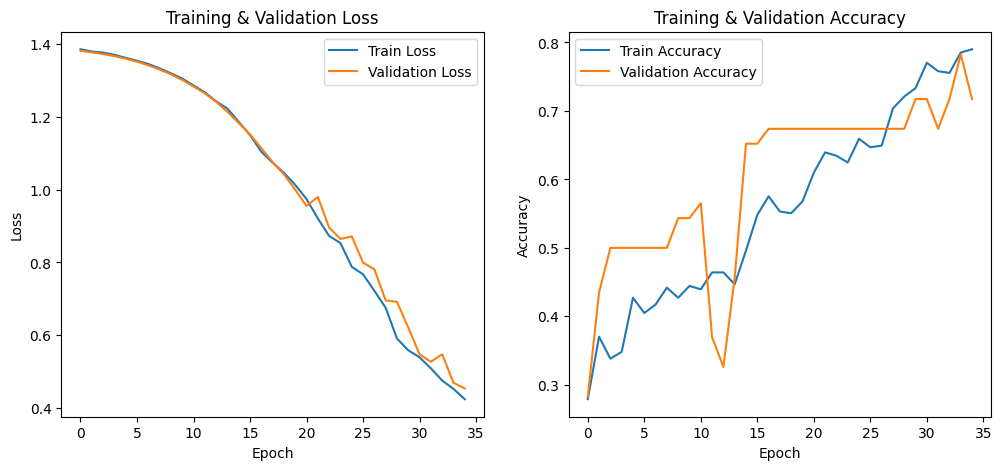

In [ ]:
import matplotlib.pyplot as plt
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense, Dropout, Bidirectional
from tensorflow.keras.optimizers import Adam

# ===============================
# Model Definition
# ===============================
model = Sequential()
model.add(Embedding(input_dim=MAX_NUM_WORDS, output_dim=128, input_length=MAX_SEQUENCE_LENGTH))
model.add(Bidirectional(LSTM(128, return_sequences=False)))
model.add(Dropout(0.7))
model.add(Dense(64, activation='relu'))
model.add(Dense(len(all_emotions), activation='softmax'))

# Compile with lower learning rate
optimizer = Adam(learning_rate=0.0001)
model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])

# ===============================
# Train the Model with increased epochs
# ===============================
history = model.fit(
    X_train, y_train,
    epochs=35,
    batch_size=64,  # or any batch size you want
    validation_split=0.1,
    shuffle=True
)

# ===============================
# Plot Training & Validation Curves
# ===============================
plt.figure(figsize=(12,5))

# Loss curve
plt.subplot(1,2,1)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Training & Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

# Accuracy curve
plt.subplot(1,2,2)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Training & Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.show()


Epoch 1/35
7/7 ━━━━━━━━━━━━━━━━━━━━ 16s 340ms/step - accuracy: 0.2642 - loss: 1.3851 - val_accuracy: 0.4130 - val_loss: 1.3818
Epoch 2/35
7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 106ms/step - accuracy: 0.3808 - loss: 1.3800 - val_accuracy: 0.5000 - val_loss: 1.3783
Epoch 3/35
7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 99ms/step - accuracy: 0.3722 - loss: 1.3758 - val_accuracy: 0.5000 - val_loss: 1.3746
Epoch 4/35
7/7 ━━━━━━━━━━━━━━━━━━━━ 2s 172ms/step - accuracy: 0.3984 - loss: 1.3723 - val_accuracy: 0.5000 - val_loss: 1.3703
Epoch 5/35
7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 155ms/step - accuracy: 0.3556 - loss: 1.3700 - val_accuracy: 0.5000 - val_loss: 1.3651
Epoch 6/35
7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 86ms/step - accuracy: 0.4354 - loss: 1.3623 - val_accuracy: 0.5217 - val_loss: 1.3587
Epoch 7/35
7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 89ms/step - accuracy: 0.4127 - loss: 1.3544 - val_accuracy: 0.5652 - val_loss: 1.3510
Epoch 8/35
7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 93ms/step - accuracy: 0.3738 - loss: 1.3480 - val_accuracy: 0.5652 - val_loss: 1.

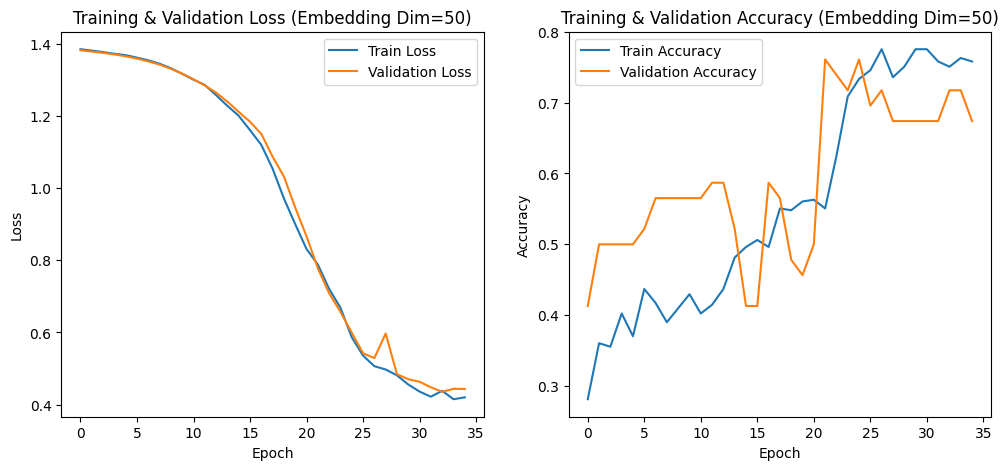

In [ ]:
import matplotlib.pyplot as plt
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense, Dropout, Bidirectional
from tensorflow.keras.optimizers import Adam

# ===============================
# Model Definition
# ===============================
model = Sequential()
model.add(Embedding(input_dim=MAX_NUM_WORDS, output_dim=50, input_length=MAX_SEQUENCE_LENGTH))
model.add(Bidirectional(LSTM(128, return_sequences=False)))
model.add(Dropout(0.5))
model.add(Dense(64, activation='relu'))
model.add(Dense(len(all_emotions), activation='softmax'))

# Compile with lower learning rate
optimizer = Adam(learning_rate=0.0001)
model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])

# ===============================
# Train the Model
# ===============================
history = model.fit(
    X_train, y_train,
    epochs=35,
    batch_size=64,
    validation_split=0.1,
    shuffle=True
)

# ===============================
# Plot Training & Validation Curves
# ===============================
plt.figure(figsize=(12,5))

plt.subplot(1,2,1)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Training & Validation Loss (Embedding Dim=50)')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1,2,2)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Training & Validation Accuracy (Embedding Dim=50)')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.show()


Epoch 1/35
7/7 ━━━━━━━━━━━━━━━━━━━━ 8s 191ms/step - accuracy: 0.2856 - loss: 1.3854 - val_accuracy: 0.2391 - val_loss: 1.3835
Epoch 2/35
7/7 ━━━━━━━━━━━━━━━━━━━━ 2s 102ms/step - accuracy: 0.2946 - loss: 1.3821 - val_accuracy: 0.2391 - val_loss: 1.3783
Epoch 3/35
7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 108ms/step - accuracy: 0.3699 - loss: 1.3762 - val_accuracy: 0.2391 - val_loss: 1.3734
Epoch 4/35
7/7 ━━━━━━━━━━━━━━━━━━━━ 2s 186ms/step - accuracy: 0.3196 - loss: 1.3723 - val_accuracy: 0.2609 - val_loss: 1.3684
Epoch 5/35
7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 193ms/step - accuracy: 0.3596 - loss: 1.3668 - val_accuracy: 0.2391 - val_loss: 1.3628
Epoch 6/35
7/7 ━━━━━━━━━━━━━━━━━━━━ 2s 118ms/step - accuracy: 0.3663 - loss: 1.3596 - val_accuracy: 0.2391 - val_loss: 1.3561
Epoch 7/35
7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 103ms/step - accuracy: 0.3565 - loss: 1.3536 - val_accuracy: 0.2826 - val_loss: 1.3480
Epoch 8/35
7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 98ms/step - accuracy: 0.3928 - loss: 1.3447 - val_accuracy: 0.2609 - val_loss: 

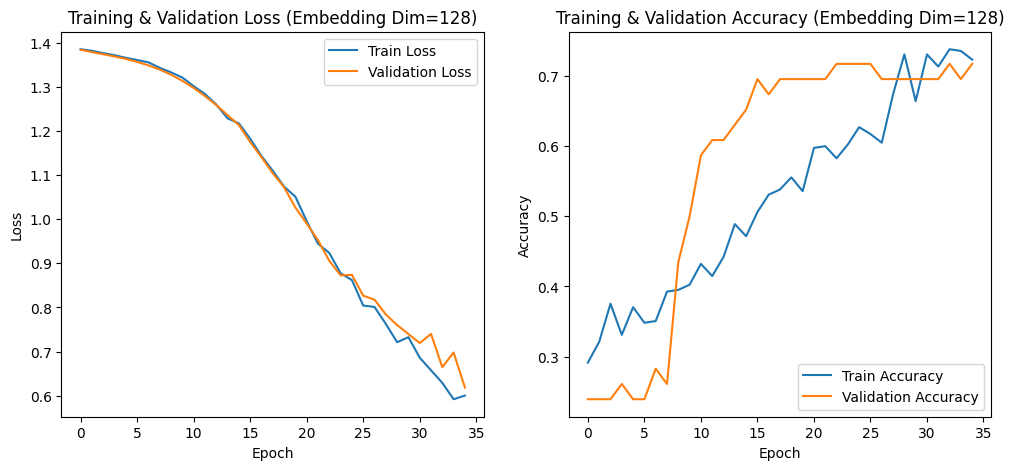

In [ ]:
import matplotlib.pyplot as plt
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense, Dropout, Bidirectional
from tensorflow.keras.optimizers import Adam

# ===============================
# Model Definition
# ===============================
model = Sequential()
model.add(Embedding(input_dim=MAX_NUM_WORDS, output_dim=128, input_length=MAX_SEQUENCE_LENGTH))
model.add(Bidirectional(LSTM(128, return_sequences=False)))
model.add(Dropout(0.7))
model.add(Dense(64, activation='relu'))
model.add(Dense(len(all_emotions), activation='softmax'))

# Compile with lower learning rate
optimizer = Adam(learning_rate=0.0001)
model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])

# ===============================
# Train the Model
# ===============================
history = model.fit(
    X_train, y_train,
    epochs=35,
    batch_size=64,
    validation_split=0.1,
    shuffle=True
)

# ===============================
# Plot Training & Validation Curves
# ===============================
plt.figure(figsize=(12,5))

plt.subplot(1,2,1)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Training & Validation Loss (Embedding Dim=128)')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1,2,2)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Training & Validation Accuracy (Embedding Dim=128)')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.show()


Epoch 1/35
7/7 ━━━━━━━━━━━━━━━━━━━━ 8s 223ms/step - accuracy: 0.3305 - loss: 1.3764 - val_accuracy: 0.2609 - val_loss: 1.3717
Epoch 2/35
7/7 ━━━━━━━━━━━━━━━━━━━━ 2s 138ms/step - accuracy: 0.3475 - loss: 1.3686 - val_accuracy: 0.5000 - val_loss: 1.3608
Epoch 3/35
7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 141ms/step - accuracy: 0.3627 - loss: 1.3584 - val_accuracy: 0.5870 - val_loss: 1.3481
Epoch 4/35
7/7 ━━━━━━━━━━━━━━━━━━━━ 2s 184ms/step - accuracy: 0.3697 - loss: 1.3418 - val_accuracy: 0.5870 - val_loss: 1.3329
Epoch 5/35
7/7 ━━━━━━━━━━━━━━━━━━━━ 2s 252ms/step - accuracy: 0.4094 - loss: 1.3245 - val_accuracy: 0.5870 - val_loss: 1.3151
Epoch 6/35
7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 157ms/step - accuracy: 0.4481 - loss: 1.3048 - val_accuracy: 0.6304 - val_loss: 1.2935
Epoch 7/35
7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 138ms/step - accuracy: 0.4633 - loss: 1.2941 - val_accuracy: 0.6522 - val_loss: 1.2687
Epoch 8/35
7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 137ms/step - accuracy: 0.5069 - loss: 1.2676 - val_accuracy: 0.6522 - val_loss:

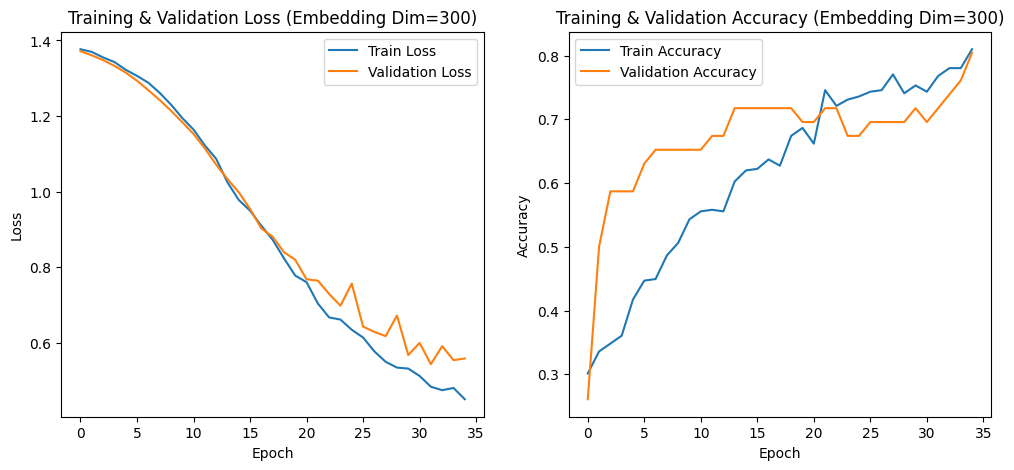

In [ ]:
import matplotlib.pyplot as plt
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense, Dropout, Bidirectional
from tensorflow.keras.optimizers import Adam

# ===============================
# Model Definition
# ===============================
model = Sequential()
model.add(Embedding(input_dim=MAX_NUM_WORDS, output_dim=300, input_length=MAX_SEQUENCE_LENGTH))
model.add(Bidirectional(LSTM(128, return_sequences=False)))
model.add(Dropout(0.7))
model.add(Dense(64, activation='relu'))
model.add(Dense(len(all_emotions), activation='softmax'))

# Compile with lower learning rate
optimizer = Adam(learning_rate=0.0001)
model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])

# ===============================
# Train the Model
# ===============================
history = model.fit(
    X_train, y_train,
    epochs=35,
    batch_size=64,
    validation_split=0.1,
    shuffle=True
)

# ===============================
# Plot Training & Validation Curves
# ===============================
plt.figure(figsize=(12,5))

plt.subplot(1,2,1)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Training & Validation Loss (Embedding Dim=300)')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1,2,2)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Training & Validation Accuracy (Embedding Dim=300)')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.show()


Epoch 1/35


/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/embedding.py:97: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


5/5 ━━━━━━━━━━━━━━━━━━━━ 8s 579ms/step - accuracy: 0.4245 - loss: 1.3732 - val_accuracy: 0.5882 - val_loss: 1.3589
Epoch 2/35
5/5 ━━━━━━━━━━━━━━━━━━━━ 4s 794ms/step - accuracy: 0.5130 - loss: 1.3539 - val_accuracy: 0.5588 - val_loss: 1.3402
Epoch 3/35
5/5 ━━━━━━━━━━━━━━━━━━━━ 4s 462ms/step - accuracy: 0.4880 - loss: 1.3365 - val_accuracy: 0.5000 - val_loss: 1.3202
Epoch 4/35
5/5 ━━━━━━━━━━━━━━━━━━━━ 3s 670ms/step - accuracy: 0.4471 - loss: 1.3158 - val_accuracy: 0.5000 - val_loss: 1.2976
Epoch 5/35
5/5 ━━━━━━━━━━━━━━━━━━━━ 5s 678ms/step - accuracy: 0.4102 - loss: 1.2939 - val_accuracy: 0.3824 - val_loss: 1.2709
Epoch 6/35
5/5 ━━━━━━━━━━━━━━━━━━━━ 4s 444ms/step - accuracy: 0.4087 - loss: 1.2675 - val_accuracy: 0.3824 - val_loss: 1.2388
Epoch 7/35
5/5 ━━━━━━━━━━━━━━━━━━━━ 2s 432ms/step - accuracy: 0.4049 - loss: 1.2305 - val_accuracy: 0.3824 - val_loss: 1.2009
Epoch 8/35
5/5 ━━━━━━━━━━━━━━━━━━━━ 2s 431ms/step - accuracy: 0.4203 - loss: 1.1885 - val_accuracy: 0.3824 - val_loss: 1.1586
Epo

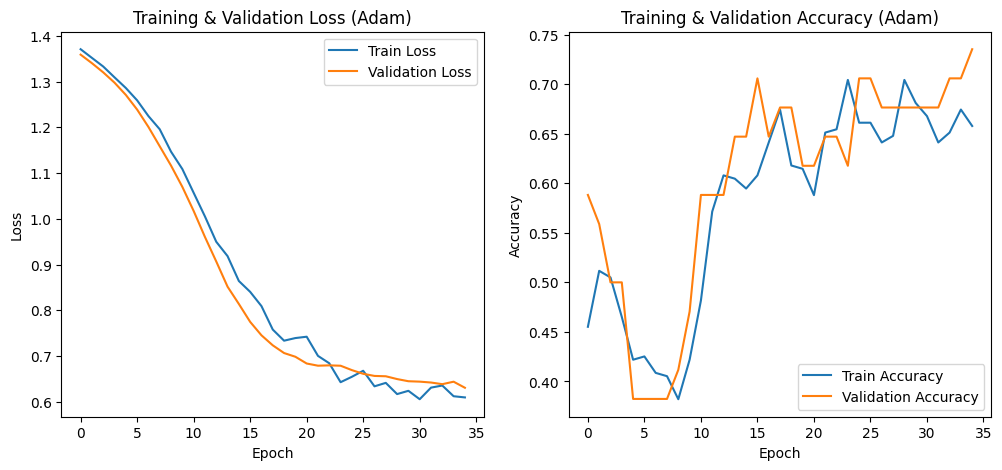

In [ ]:
# ================================
# Imports
# ================================
import matplotlib.pyplot as plt
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense, Dropout, Bidirectional
from tensorflow.keras.optimizers import Adam
import pandas as pd
import numpy as np
import re
import string
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

# ===============================
# Define required variables
# ===============================
MAX_NUM_WORDS = 10000            # Vocabulary size
MAX_SEQUENCE_LENGTH = 100        # Max sequence length after padding
all_emotions = ['happy', 'sad', 'angry', 'fear', 'love', 'surprise']  # Example classes

# ===============================
# Load and preprocess data (reusing steps from previous cells)
# ===============================
# Load your dataset
df = pd.read_excel("Express your emotions through text (Responses).xlsx", engine="openpyxl")

# Rename columns (assuming your columns are in this order based on previous cells)
df = df.rename(columns={
    df.columns[0]: 'happy',
    df.columns[1]: 'sad',
    df.columns[2]: 'angry',
    df.columns[3]: 'fear'
})

# Define cleaning and gibberish functions (reusing from previous cells)
def clean_text(text):
    text = str(text).lower()
    text = re.sub(r'\d+', '', text)
    text = text.translate(str.maketrans('', '', string.punctuation))
    text = re.sub(r'\s+', ' ', text).strip()
    return text

def is_gibberish(text):
    if len(text) < 4:
        return True
    if not re.search(r'[aeiou]', text):
        return True
    return False

# Melt to long format
existing_cols = [col for col in ['happy','sad','angry','fear'] if col in df.columns]
df_melted = df.melt(value_vars=existing_cols, var_name='emotion', value_name='text')
df_melted = df_melted.dropna(subset=['text'])
df_melted['cleaned_text'] = df_melted['text'].apply(clean_text)
df_melted['is_gibberish'] = df_melted['cleaned_text'].apply(is_gibberish)
df_clean = df_melted[df_melted['is_gibberish']==False].copy()
df_clean.drop(columns=['is_gibberish'], inplace=True)
df_valid = df_clean.reset_index(drop=True)


# Tokenization & Sequences
tokenizer = Tokenizer(num_words=MAX_NUM_WORDS, oov_token='<OOV>')
tokenizer.fit_on_texts(df_valid['cleaned_text'])
df_valid['token_sequence'] = tokenizer.texts_to_sequences(df_valid['cleaned_text'])
X = pad_sequences(df_valid['token_sequence'], maxlen=MAX_SEQUENCE_LENGTH, padding='post', truncating='post')

# Labels
emotion_to_label = {emo:i for i, emo in enumerate(existing_cols)} # Use existing_cols for mapping
df_valid['emotion_label'] = df_valid['emotion'].map(emotion_to_label)
one_hot_labels = pd.get_dummies(df_valid['emotion'], prefix='emotion').reindex(
    columns=[f"emotion_{emo}" for emo in existing_cols], fill_value=0 # Use existing_cols for one-hot columns
)
y = one_hot_labels.values.astype(np.float32)  # ensure numeric type

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)


# ===============================
# Model Definition
# ===============================
model = Sequential()
model.add(Embedding(input_dim=MAX_NUM_WORDS, output_dim=128, input_length=MAX_SEQUENCE_LENGTH))
model.add(Bidirectional(LSTM(128, return_sequences=False)))
model.add(Dropout(0.5))
model.add(Dense(64, activation='relu'))
model.add(Dense(len(existing_cols), activation='softmax')) # Use len(existing_cols) for output layer

# Compile with Adam optimizer
optimizer = Adam(learning_rate=0.0001)
model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])

# ===============================
# Train the Model
# ===============================
# Make sure X_train and y_train are properly prepared numpy arrays
# X_train should be padded sequences, y_train should be one-hot encoded
history = model.fit(
    X_train, y_train,
    epochs=35,
    batch_size=64,
    validation_split=0.1,
    shuffle=True
)

# ===============================
# Plot Training & Validation Curves
# ===============================
plt.figure(figsize=(12,5))

# Loss curve
plt.subplot(1,2,1)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Training & Validation Loss (Adam)')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

# Accuracy curve
plt.subplot(1,2,2)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Training & Validation Accuracy (Adam)')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.show()

Epoch 1/35


/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/embedding.py:97: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


5/5 ━━━━━━━━━━━━━━━━━━━━ 9s 817ms/step - accuracy: 0.1657 - loss: 1.3963 - val_accuracy: 0.0000e+00 - val_loss: 1.3946
Epoch 2/35
5/5 ━━━━━━━━━━━━━━━━━━━━ 2s 441ms/step - accuracy: 0.1380 - loss: 1.3978 - val_accuracy: 0.0588 - val_loss: 1.3938
Epoch 3/35
5/5 ━━━━━━━━━━━━━━━━━━━━ 2s 428ms/step - accuracy: 0.1742 - loss: 1.3948 - val_accuracy: 0.2353 - val_loss: 1.3927
Epoch 4/35
5/5 ━━━━━━━━━━━━━━━━━━━━ 2s 436ms/step - accuracy: 0.2345 - loss: 1.3928 - val_accuracy: 0.2941 - val_loss: 1.3914
Epoch 5/35
5/5 ━━━━━━━━━━━━━━━━━━━━ 3s 551ms/step - accuracy: 0.2200 - loss: 1.3927 - val_accuracy: 0.2941 - val_loss: 1.3901
Epoch 6/35
5/5 ━━━━━━━━━━━━━━━━━━━━ 5s 448ms/step - accuracy: 0.1922 - loss: 1.3917 - val_accuracy: 0.3235 - val_loss: 1.3887
Epoch 7/35
5/5 ━━━━━━━━━━━━━━━━━━━━ 2s 423ms/step - accuracy: 0.2297 - loss: 1.3925 - val_accuracy: 0.3235 - val_loss: 1.3872
Epoch 8/35
5/5 ━━━━━━━━━━━━━━━━━━━━ 2s 431ms/step - accuracy: 0.2465 - loss: 1.3888 - val_accuracy: 0.3529 - val_loss: 1.3858

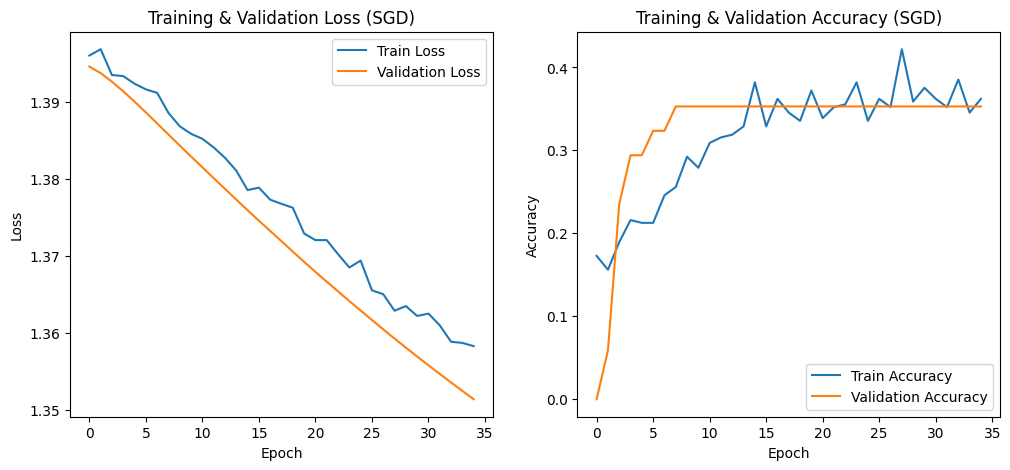

In [ ]:
import matplotlib.pyplot as plt
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense, Dropout, Bidirectional
from tensorflow.keras.optimizers import SGD

# ===============================
# Model Definition
# ===============================
model = Sequential()
model.add(Embedding(input_dim=MAX_NUM_WORDS, output_dim=128, input_length=MAX_SEQUENCE_LENGTH))
model.add(Bidirectional(LSTM(128, return_sequences=False)))
model.add(Dropout(0.5))
model.add(Dense(64, activation='relu'))
model.add(Dense(len(existing_cols), activation='softmax')) # Use len(existing_cols) for the output layer

# Compile with SGD optimizer
optimizer = SGD(learning_rate=0.0001, momentum=0.9)
model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])

# ===============================
# Train the Model
# ===============================
history = model.fit(
    X_train, y_train,
    epochs=35,
    batch_size=64,
    validation_split=0.1,
    shuffle=True
)

# ===============================
# Plot Training & Validation Curves
# ===============================
plt.figure(figsize=(12,5))

plt.subplot(1,2,1)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Training & Validation Loss (SGD)')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1,2,2)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Training & Validation Accuracy (SGD)')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.show()